In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [5]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 170795


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [8]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
5,5,322430009006,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,56,56,1,10.0,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,0.648868,2012,1.087793


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [11]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.IsoPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 4.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 5.5)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,5) + translate(team_stat_pack.OppSRDiff, -1,1,0,5)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.05 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[min(100, (x.yard_line + x.yards_gained))].ep - ep_data.iloc[x.yard_line].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,4.793313,0.086625
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.706687,-0.086625


In [66]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    if (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
    stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
    print(f"[Local] Grouping box score rows by GameID...")
    groups = stored_game_boxes.groupby('GameID')
    print(f"[Local] Generated {len(groups)} box score groups by GameID.")
    current = 0
    for (name, group) in groups:
        print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
        group_ratings = group['5FR']
        top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
        bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
        group['5FRDiff'] = [top_diff, bot_diff]
        print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
        current+=1
    print(f"[Local] Finished updating box scores with new 5FR margins.")
print(f"[Local] Writing updated box scores to file...")
stored_game_boxes.to_csv("results/box-scores.csv", sep=",")
print(f"[Local] Wrote updated box scores to file.")

Relying on 'stored_game_boxes' currently loaded into memory
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...
[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...
[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...
[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...
[8/5670] Updated 5FR Margin for game_id 322440024.
[9/5670] Updating 5FR Margin for game_id 322440127...
[9/5670] Updated 5FR Margin for game_id 322440127.
[10/5670] Updating 5FR Margin for game_id 322442633...
[10/5670] Updated 5FR Margin for game_id 322442633.
[11/5670] Updating 5FR Margin for game_id 322450002...
[11/5670] Updated 5FR Margin for game_id 322450002.
[12/5670] Updating 5FR Margin for game_id 322450005...
[12/5670] Updated 5FR Margin for game_id 322450005

[83/5670] Updated 5FR Margin for game_id 322522579.
[84/5670] Updating 5FR Margin for game_id 322522633...
[84/5670] Updated 5FR Margin for game_id 322522633.
[85/5670] Updating 5FR Margin for game_id 322522653...
[85/5670] Updated 5FR Margin for game_id 322522653.
[86/5670] Updating 5FR Margin for game_id 322522751...
[86/5670] Updated 5FR Margin for game_id 322522751.
[87/5670] Updating 5FR Margin for game_id 322570058...
[87/5670] Updated 5FR Margin for game_id 322570058.
[88/5670] Updating 5FR Margin for game_id 322582439...
[88/5670] Updated 5FR Margin for game_id 322582439.
[89/5670] Updating 5FR Margin for game_id 322590002...
[89/5670] Updated 5FR Margin for game_id 322590002.
[90/5670] Updating 5FR Margin for game_id 322590008...
[90/5670] Updated 5FR Margin for game_id 322590008.
[91/5670] Updating 5FR Margin for game_id 322590023...
[91/5670] Updated 5FR Margin for game_id 322590023.
[92/5670] Updating 5FR Margin for game_id 322590024...
[92/5670] Updated 5FR Margin for game

[159/5670] Updated 5FR Margin for game_id 322660213.
[160/5670] Updating 5FR Margin for game_id 322660242...
[160/5670] Updated 5FR Margin for game_id 322660242.
[161/5670] Updating 5FR Margin for game_id 322660249...
[161/5670] Updated 5FR Margin for game_id 322660249.
[162/5670] Updating 5FR Margin for game_id 322660259...
[162/5670] Updated 5FR Margin for game_id 322660259.
[163/5670] Updating 5FR Margin for game_id 322660265...
[163/5670] Updated 5FR Margin for game_id 322660265.
[164/5670] Updating 5FR Margin for game_id 322660275...
[164/5670] Updated 5FR Margin for game_id 322660275.
[165/5670] Updating 5FR Margin for game_id 322660277...
[165/5670] Updated 5FR Margin for game_id 322660277.
[166/5670] Updating 5FR Margin for game_id 322660333...
[166/5670] Updated 5FR Margin for game_id 322660333.
[167/5670] Updating 5FR Margin for game_id 322660344...
[167/5670] Updated 5FR Margin for game_id 322660344.
[168/5670] Updating 5FR Margin for game_id 322660356...
[168/5670] Updated 

[240/5670] Updated 5FR Margin for game_id 322800096.
[241/5670] Updating 5FR Margin for game_id 322800120...
[241/5670] Updated 5FR Margin for game_id 322800120.
[242/5670] Updating 5FR Margin for game_id 322800142...
[242/5670] Updated 5FR Margin for game_id 322800142.
[243/5670] Updating 5FR Margin for game_id 322800145...
[243/5670] Updated 5FR Margin for game_id 322800145.
[244/5670] Updating 5FR Margin for game_id 322800150...
[244/5670] Updated 5FR Margin for game_id 322800150.
[245/5670] Updating 5FR Margin for game_id 322800152...
[245/5670] Updated 5FR Margin for game_id 322800152.
[246/5670] Updating 5FR Margin for game_id 322800153...
[246/5670] Updated 5FR Margin for game_id 322800153.
[247/5670] Updating 5FR Margin for game_id 322800164...
[247/5670] Updated 5FR Margin for game_id 322800164.
[248/5670] Updating 5FR Margin for game_id 322800167...
[248/5670] Updated 5FR Margin for game_id 322800167.
[249/5670] Updating 5FR Margin for game_id 322800194...
[249/5670] Updated 

[325/5670] Updated 5FR Margin for game_id 322872433.
[326/5670] Updating 5FR Margin for game_id 322872439...
[326/5670] Updated 5FR Margin for game_id 322872439.
[327/5670] Updating 5FR Margin for game_id 322872459...
[327/5670] Updated 5FR Margin for game_id 322872459.
[328/5670] Updating 5FR Margin for game_id 322872509...
[328/5670] Updated 5FR Margin for game_id 322872509.
[329/5670] Updating 5FR Margin for game_id 322872641...
[329/5670] Updated 5FR Margin for game_id 322872641.
[330/5670] Updating 5FR Margin for game_id 322872751...
[330/5670] Updated 5FR Margin for game_id 322872751.
[331/5670] Updating 5FR Margin for game_id 322900249...
[331/5670] Updated 5FR Margin for game_id 322900249.
[332/5670] Updating 5FR Margin for game_id 322920009...
[332/5670] Updated 5FR Margin for game_id 322920009.
[333/5670] Updating 5FR Margin for game_id 322922567...
[333/5670] Updated 5FR Margin for game_id 322922567.
[334/5670] Updating 5FR Margin for game_id 322930183...
[334/5670] Updated 

[405/5670] Updated 5FR Margin for game_id 323010135.
[406/5670] Updating 5FR Margin for game_id 323010142...
[406/5670] Updated 5FR Margin for game_id 323010142.
[407/5670] Updating 5FR Margin for game_id 323010151...
[407/5670] Updated 5FR Margin for game_id 323010151.
[408/5670] Updating 5FR Margin for game_id 323010153...
[408/5670] Updated 5FR Margin for game_id 323010153.
[409/5670] Updating 5FR Margin for game_id 323010158...
[409/5670] Updated 5FR Margin for game_id 323010158.
[410/5670] Updating 5FR Margin for game_id 323010164...
[410/5670] Updated 5FR Margin for game_id 323010164.
[411/5670] Updating 5FR Margin for game_id 323010166...
[411/5670] Updated 5FR Margin for game_id 323010166.
[412/5670] Updating 5FR Margin for game_id 323010167...
[412/5670] Updated 5FR Margin for game_id 323010167.
[413/5670] Updating 5FR Margin for game_id 323010189...
[413/5670] Updated 5FR Margin for game_id 323010189.
[414/5670] Updating 5FR Margin for game_id 323010193...
[414/5670] Updated 

[486/5670] Updated 5FR Margin for game_id 323082306.
[487/5670] Updating 5FR Margin for game_id 323082309...
[487/5670] Updated 5FR Margin for game_id 323082309.
[488/5670] Updating 5FR Margin for game_id 323082348...
[488/5670] Updated 5FR Margin for game_id 323082348.
[489/5670] Updating 5FR Margin for game_id 323082426...
[489/5670] Updated 5FR Margin for game_id 323082426.
[490/5670] Updating 5FR Margin for game_id 323082433...
[490/5670] Updated 5FR Margin for game_id 323082433.
[491/5670] Updating 5FR Margin for game_id 323082439...
[491/5670] Updated 5FR Margin for game_id 323082439.
[492/5670] Updating 5FR Margin for game_id 323082459...
[492/5670] Updated 5FR Margin for game_id 323082459.
[493/5670] Updating 5FR Margin for game_id 323082509...
[493/5670] Updated 5FR Margin for game_id 323082509.
[494/5670] Updating 5FR Margin for game_id 323082572...
[494/5670] Updated 5FR Margin for game_id 323082572.
[495/5670] Updating 5FR Margin for game_id 323082633...
[495/5670] Updated 

[563/5670] Updated 5FR Margin for game_id 323220038.
[564/5670] Updating 5FR Margin for game_id 323220059...
[564/5670] Updated 5FR Margin for game_id 323220059.
[565/5670] Updating 5FR Margin for game_id 323220061...
[565/5670] Updated 5FR Margin for game_id 323220061.
[566/5670] Updating 5FR Margin for game_id 323220068...
[566/5670] Updated 5FR Margin for game_id 323220068.
[567/5670] Updating 5FR Margin for game_id 323220087...
[567/5670] Updated 5FR Margin for game_id 323220087.
[568/5670] Updating 5FR Margin for game_id 323220099...
[568/5670] Updated 5FR Margin for game_id 323220099.
[569/5670] Updating 5FR Margin for game_id 323220103...
[569/5670] Updated 5FR Margin for game_id 323220103.
[570/5670] Updating 5FR Margin for game_id 323220120...
[570/5670] Updated 5FR Margin for game_id 323220120.
[571/5670] Updating 5FR Margin for game_id 323220127...
[571/5670] Updated 5FR Margin for game_id 323220127.
[572/5670] Updating 5FR Margin for game_id 323220130...
[572/5670] Updated 

[639/5670] Updated 5FR Margin for game_id 323290194.
[640/5670] Updating 5FR Margin for game_id 323290201...
[640/5670] Updated 5FR Margin for game_id 323290201.
[641/5670] Updating 5FR Margin for game_id 323290204...
[641/5670] Updated 5FR Margin for game_id 323290204.
[642/5670] Updating 5FR Margin for game_id 323290213...
[642/5670] Updated 5FR Margin for game_id 323290213.
[643/5670] Updating 5FR Margin for game_id 323290221...
[643/5670] Updated 5FR Margin for game_id 323290221.
[644/5670] Updating 5FR Margin for game_id 323290228...
[644/5670] Updated 5FR Margin for game_id 323290228.
[645/5670] Updating 5FR Margin for game_id 323290235...
[645/5670] Updated 5FR Margin for game_id 323290235.
[646/5670] Updating 5FR Margin for game_id 323290245...
[646/5670] Updated 5FR Margin for game_id 323290245.
[647/5670] Updating 5FR Margin for game_id 323290248...
[647/5670] Updated 5FR Margin for game_id 323290248.
[648/5670] Updating 5FR Margin for game_id 323290259...
[648/5670] Updated 

[720/5670] Updated 5FR Margin for game_id 332432572.
[721/5670] Updating 5FR Margin for game_id 332432628...
[721/5670] Updated 5FR Margin for game_id 332432628.
[722/5670] Updating 5FR Margin for game_id 332432653...
[722/5670] Updated 5FR Margin for game_id 332432653.
[723/5670] Updating 5FR Margin for game_id 332440036...
[723/5670] Updated 5FR Margin for game_id 332440036.
[724/5670] Updating 5FR Margin for game_id 332440097...
[724/5670] Updated 5FR Margin for game_id 332440097.
[725/5670] Updating 5FR Margin for game_id 332450221...
[725/5670] Updated 5FR Margin for game_id 332450221.
[726/5670] Updating 5FR Margin for game_id 332480151...
[726/5670] Updated 5FR Margin for game_id 332480151.
[727/5670] Updating 5FR Margin for game_id 332490103...
[727/5670] Updated 5FR Margin for game_id 332490103.
[728/5670] Updating 5FR Margin for game_id 332492229...
[728/5670] Updated 5FR Margin for game_id 332492229.
[729/5670] Updating 5FR Margin for game_id 332500002...
[729/5670] Updated 

[802/5670] Updated 5FR Margin for game_id 332570349.
[803/5670] Updating 5FR Margin for game_id 332570356...
[803/5670] Updated 5FR Margin for game_id 332570356.
[804/5670] Updating 5FR Margin for game_id 332572306...
[804/5670] Updated 5FR Margin for game_id 332572306.
[805/5670] Updating 5FR Margin for game_id 332572393...
[805/5670] Updated 5FR Margin for game_id 332572393.
[806/5670] Updating 5FR Margin for game_id 332572439...
[806/5670] Updated 5FR Margin for game_id 332572439.
[807/5670] Updating 5FR Margin for game_id 332572483...
[807/5670] Updated 5FR Margin for game_id 332572483.
[808/5670] Updating 5FR Margin for game_id 332572509...
[808/5670] Updated 5FR Margin for game_id 332572509.
[809/5670] Updating 5FR Margin for game_id 332572579...
[809/5670] Updated 5FR Margin for game_id 332572579.
[810/5670] Updating 5FR Margin for game_id 332620152...
[810/5670] Updated 5FR Margin for game_id 332620152.
[811/5670] Updating 5FR Margin for game_id 332630278...
[811/5670] Updated 

[878/5670] Updated 5FR Margin for game_id 332710221.
[879/5670] Updating 5FR Margin for game_id 332710228...
[879/5670] Updated 5FR Margin for game_id 332710228.
[880/5670] Updating 5FR Margin for game_id 332710238...
[880/5670] Updated 5FR Margin for game_id 332710238.
[881/5670] Updating 5FR Margin for game_id 332710242...
[881/5670] Updated 5FR Margin for game_id 332710242.
[882/5670] Updating 5FR Margin for game_id 332710264...
[882/5670] Updated 5FR Margin for game_id 332710264.
[883/5670] Updating 5FR Margin for game_id 332710265...
[883/5670] Updated 5FR Margin for game_id 332710265.
[884/5670] Updating 5FR Margin for game_id 332710277...
[884/5670] Updated 5FR Margin for game_id 332710277.
[885/5670] Updating 5FR Margin for game_id 332710326...
[885/5670] Updated 5FR Margin for game_id 332710326.
[886/5670] Updating 5FR Margin for game_id 332710333...
[886/5670] Updated 5FR Margin for game_id 332710333.
[887/5670] Updating 5FR Margin for game_id 332710356...
[887/5670] Updated 

[954/5670] Updated 5FR Margin for game_id 332782655.
[955/5670] Updating 5FR Margin for game_id 332830030...
[955/5670] Updated 5FR Margin for game_id 332830030.
[956/5670] Updating 5FR Margin for game_id 332830097...
[956/5670] Updated 5FR Margin for game_id 332830097.
[957/5670] Updating 5FR Margin for game_id 332832005...
[957/5670] Updated 5FR Margin for game_id 332832005.
[958/5670] Updating 5FR Margin for game_id 332842132...
[958/5670] Updated 5FR Margin for game_id 332842132.
[959/5670] Updating 5FR Margin for game_id 332850008...
[959/5670] Updated 5FR Margin for game_id 332850008.
[960/5670] Updating 5FR Margin for game_id 332850009...
[960/5670] Updated 5FR Margin for game_id 332850009.
[961/5670] Updating 5FR Margin for game_id 332850026...
[961/5670] Updated 5FR Margin for game_id 332850026.
[962/5670] Updating 5FR Margin for game_id 332850036...
[962/5670] Updated 5FR Margin for game_id 332850036.
[963/5670] Updating 5FR Margin for game_id 332850041...
[963/5670] Updated 

[1034/5670] Updated 5FR Margin for game_id 332920248.
[1035/5670] Updating 5FR Margin for game_id 332920258...
[1035/5670] Updated 5FR Margin for game_id 332920258.
[1036/5670] Updating 5FR Margin for game_id 332920277...
[1036/5670] Updated 5FR Margin for game_id 332920277.
[1037/5670] Updating 5FR Margin for game_id 332920278...
[1037/5670] Updated 5FR Margin for game_id 332920278.
[1038/5670] Updating 5FR Margin for game_id 332920326...
[1038/5670] Updated 5FR Margin for game_id 332920326.
[1039/5670] Updating 5FR Margin for game_id 332920333...
[1039/5670] Updated 5FR Margin for game_id 332920333.
[1040/5670] Updating 5FR Margin for game_id 332920356...
[1040/5670] Updated 5FR Margin for game_id 332920356.
[1041/5670] Updating 5FR Margin for game_id 332922084...
[1041/5670] Updated 5FR Margin for game_id 332922084.
[1042/5670] Updating 5FR Margin for game_id 332922117...
[1042/5670] Updated 5FR Margin for game_id 332922117.
[1043/5670] Updating 5FR Margin for game_id 332922132...
[

[1111/5670] Updated 5FR Margin for game_id 333060006.
[1112/5670] Updating 5FR Margin for game_id 333060008...
[1112/5670] Updated 5FR Margin for game_id 333060008.
[1113/5670] Updating 5FR Margin for game_id 333060021...
[1113/5670] Updated 5FR Margin for game_id 333060021.
[1114/5670] Updating 5FR Margin for game_id 333060025...
[1114/5670] Updated 5FR Margin for game_id 333060025.
[1115/5670] Updating 5FR Margin for game_id 333060026...
[1115/5670] Updated 5FR Margin for game_id 333060026.
[1116/5670] Updating 5FR Margin for game_id 333060036...
[1116/5670] Updated 5FR Margin for game_id 333060036.
[1117/5670] Updating 5FR Margin for game_id 333060052...
[1117/5670] Updated 5FR Margin for game_id 333060052.
[1118/5670] Updating 5FR Margin for game_id 333060057...
[1118/5670] Updated 5FR Margin for game_id 333060057.
[1119/5670] Updating 5FR Margin for game_id 333060059...
[1119/5670] Updated 5FR Margin for game_id 333060059.
[1120/5670] Updating 5FR Margin for game_id 333060084...
[

[1185/5670] Updated 5FR Margin for game_id 333130276.
[1186/5670] Updating 5FR Margin for game_id 333130277...
[1186/5670] Updated 5FR Margin for game_id 333130277.
[1187/5670] Updating 5FR Margin for game_id 333130333...
[1187/5670] Updated 5FR Margin for game_id 333130333.
[1188/5670] Updating 5FR Margin for game_id 333130349...
[1188/5670] Updated 5FR Margin for game_id 333130349.
[1189/5670] Updating 5FR Margin for game_id 333132116...
[1189/5670] Updated 5FR Margin for game_id 333132116.
[1190/5670] Updating 5FR Margin for game_id 333132132...
[1190/5670] Updated 5FR Margin for game_id 333132132.
[1191/5670] Updating 5FR Margin for game_id 333132199...
[1191/5670] Updated 5FR Margin for game_id 333132199.
[1192/5670] Updating 5FR Margin for game_id 333132348...
[1192/5670] Updated 5FR Margin for game_id 333132348.
[1193/5670] Updating 5FR Margin for game_id 333132390...
[1193/5670] Updated 5FR Margin for game_id 333132390.
[1194/5670] Updating 5FR Margin for game_id 333132393...
[

[1263/5670] Updated 5FR Margin for game_id 333270021.
[1264/5670] Updating 5FR Margin for game_id 333270024...
[1264/5670] Updated 5FR Margin for game_id 333270024.
[1265/5670] Updating 5FR Margin for game_id 333270026...
[1265/5670] Updated 5FR Margin for game_id 333270026.
[1266/5670] Updating 5FR Margin for game_id 333270038...
[1266/5670] Updated 5FR Margin for game_id 333270038.
[1267/5670] Updating 5FR Margin for game_id 333270057...
[1267/5670] Updated 5FR Margin for game_id 333270057.
[1268/5670] Updating 5FR Margin for game_id 333270058...
[1268/5670] Updated 5FR Margin for game_id 333270058.
[1269/5670] Updating 5FR Margin for game_id 333270061...
[1269/5670] Updated 5FR Margin for game_id 333270061.
[1270/5670] Updating 5FR Margin for game_id 333270066...
[1270/5670] Updated 5FR Margin for game_id 333270066.
[1271/5670] Updating 5FR Margin for game_id 333270077...
[1271/5670] Updated 5FR Margin for game_id 333270077.
[1272/5670] Updating 5FR Margin for game_id 333270087...
[

[1338/5670] Updated 5FR Margin for game_id 333340084.
[1339/5670] Updating 5FR Margin for game_id 333340096...
[1339/5670] Updated 5FR Margin for game_id 333340096.
[1340/5670] Updating 5FR Margin for game_id 333340098...
[1340/5670] Updated 5FR Margin for game_id 333340098.
[1341/5670] Updating 5FR Margin for game_id 333340127...
[1341/5670] Updated 5FR Margin for game_id 333340127.
[1342/5670] Updating 5FR Margin for game_id 333340130...
[1342/5670] Updated 5FR Margin for game_id 333340130.
[1343/5670] Updating 5FR Margin for game_id 333340142...
[1343/5670] Updated 5FR Margin for game_id 333340142.
[1344/5670] Updating 5FR Margin for game_id 333340152...
[1344/5670] Updated 5FR Margin for game_id 333340152.
[1345/5670] Updating 5FR Margin for game_id 333340153...
[1345/5670] Updated 5FR Margin for game_id 333340153.
[1346/5670] Updating 5FR Margin for game_id 333340183...
[1346/5670] Updated 5FR Margin for game_id 333340183.
[1347/5670] Updating 5FR Margin for game_id 333340202...
[

[1417/5670] Updated 5FR Margin for game_id 400547685.
[1418/5670] Updating 5FR Margin for game_id 400547686...
[1418/5670] Updated 5FR Margin for game_id 400547686.
[1419/5670] Updating 5FR Margin for game_id 400547687...
[1419/5670] Updated 5FR Margin for game_id 400547687.
[1420/5670] Updating 5FR Margin for game_id 400547688...
[1420/5670] Updated 5FR Margin for game_id 400547688.
[1421/5670] Updating 5FR Margin for game_id 400547689...
[1421/5670] Updated 5FR Margin for game_id 400547689.
[1422/5670] Updating 5FR Margin for game_id 400547690...
[1422/5670] Updated 5FR Margin for game_id 400547690.
[1423/5670] Updating 5FR Margin for game_id 400547691...
[1423/5670] Updated 5FR Margin for game_id 400547691.
[1424/5670] Updating 5FR Margin for game_id 400547692...
[1424/5670] Updated 5FR Margin for game_id 400547692.
[1425/5670] Updating 5FR Margin for game_id 400547693...
[1425/5670] Updated 5FR Margin for game_id 400547693.
[1426/5670] Updating 5FR Margin for game_id 400547694...
[

[1491/5670] Updated 5FR Margin for game_id 400547765.
[1492/5670] Updating 5FR Margin for game_id 400547766...
[1492/5670] Updated 5FR Margin for game_id 400547766.
[1493/5670] Updating 5FR Margin for game_id 400547767...
[1493/5670] Updated 5FR Margin for game_id 400547767.
[1494/5670] Updating 5FR Margin for game_id 400547768...
[1494/5670] Updated 5FR Margin for game_id 400547768.
[1495/5670] Updating 5FR Margin for game_id 400547769...
[1495/5670] Updated 5FR Margin for game_id 400547769.
[1496/5670] Updating 5FR Margin for game_id 400547770...
[1496/5670] Updated 5FR Margin for game_id 400547770.
[1497/5670] Updating 5FR Margin for game_id 400547771...
[1497/5670] Updated 5FR Margin for game_id 400547771.
[1498/5670] Updating 5FR Margin for game_id 400547773...
[1498/5670] Updated 5FR Margin for game_id 400547773.
[1499/5670] Updating 5FR Margin for game_id 400547774...
[1499/5670] Updated 5FR Margin for game_id 400547774.
[1500/5670] Updating 5FR Margin for game_id 400547775...
[

[1572/5670] Updated 5FR Margin for game_id 400547865.
[1573/5670] Updating 5FR Margin for game_id 400547866...
[1573/5670] Updated 5FR Margin for game_id 400547866.
[1574/5670] Updating 5FR Margin for game_id 400547867...
[1574/5670] Updated 5FR Margin for game_id 400547867.
[1575/5670] Updating 5FR Margin for game_id 400547868...
[1575/5670] Updated 5FR Margin for game_id 400547868.
[1576/5670] Updating 5FR Margin for game_id 400547869...
[1576/5670] Updated 5FR Margin for game_id 400547869.
[1577/5670] Updating 5FR Margin for game_id 400547870...
[1577/5670] Updated 5FR Margin for game_id 400547870.
[1578/5670] Updating 5FR Margin for game_id 400547871...
[1578/5670] Updated 5FR Margin for game_id 400547871.
[1579/5670] Updating 5FR Margin for game_id 400547872...
[1579/5670] Updated 5FR Margin for game_id 400547872.
[1580/5670] Updating 5FR Margin for game_id 400547873...
[1580/5670] Updated 5FR Margin for game_id 400547873.
[1581/5670] Updating 5FR Margin for game_id 400547874...
[

[1646/5670] Updated 5FR Margin for game_id 400547944.
[1647/5670] Updating 5FR Margin for game_id 400547945...
[1647/5670] Updated 5FR Margin for game_id 400547945.
[1648/5670] Updating 5FR Margin for game_id 400547946...
[1648/5670] Updated 5FR Margin for game_id 400547946.
[1649/5670] Updating 5FR Margin for game_id 400547947...
[1649/5670] Updated 5FR Margin for game_id 400547947.
[1650/5670] Updating 5FR Margin for game_id 400547948...
[1650/5670] Updated 5FR Margin for game_id 400547948.
[1651/5670] Updating 5FR Margin for game_id 400547949...
[1651/5670] Updated 5FR Margin for game_id 400547949.
[1652/5670] Updating 5FR Margin for game_id 400547950...
[1652/5670] Updated 5FR Margin for game_id 400547950.
[1653/5670] Updating 5FR Margin for game_id 400547951...
[1653/5670] Updated 5FR Margin for game_id 400547951.
[1654/5670] Updating 5FR Margin for game_id 400547953...
[1654/5670] Updated 5FR Margin for game_id 400547953.
[1655/5670] Updating 5FR Margin for game_id 400547954...
[

[1721/5670] Updated 5FR Margin for game_id 400548035.
[1722/5670] Updating 5FR Margin for game_id 400548036...
[1722/5670] Updated 5FR Margin for game_id 400548036.
[1723/5670] Updating 5FR Margin for game_id 400548037...
[1723/5670] Updated 5FR Margin for game_id 400548037.
[1724/5670] Updating 5FR Margin for game_id 400548038...
[1724/5670] Updated 5FR Margin for game_id 400548038.
[1725/5670] Updating 5FR Margin for game_id 400548039...
[1725/5670] Updated 5FR Margin for game_id 400548039.
[1726/5670] Updating 5FR Margin for game_id 400548040...
[1726/5670] Updated 5FR Margin for game_id 400548040.
[1727/5670] Updating 5FR Margin for game_id 400548041...
[1727/5670] Updated 5FR Margin for game_id 400548041.
[1728/5670] Updating 5FR Margin for game_id 400548042...
[1728/5670] Updated 5FR Margin for game_id 400548042.
[1729/5670] Updating 5FR Margin for game_id 400548043...
[1729/5670] Updated 5FR Margin for game_id 400548043.
[1730/5670] Updating 5FR Margin for game_id 400548044...
[

[1800/5670] Updated 5FR Margin for game_id 400548135.
[1801/5670] Updating 5FR Margin for game_id 400548136...
[1801/5670] Updated 5FR Margin for game_id 400548136.
[1802/5670] Updating 5FR Margin for game_id 400548137...
[1802/5670] Updated 5FR Margin for game_id 400548137.
[1803/5670] Updating 5FR Margin for game_id 400548138...
[1803/5670] Updated 5FR Margin for game_id 400548138.
[1804/5670] Updating 5FR Margin for game_id 400548139...
[1804/5670] Updated 5FR Margin for game_id 400548139.
[1805/5670] Updating 5FR Margin for game_id 400548140...
[1805/5670] Updated 5FR Margin for game_id 400548140.
[1806/5670] Updating 5FR Margin for game_id 400548141...
[1806/5670] Updated 5FR Margin for game_id 400548141.
[1807/5670] Updating 5FR Margin for game_id 400548142...
[1807/5670] Updated 5FR Margin for game_id 400548142.
[1808/5670] Updating 5FR Margin for game_id 400548143...
[1808/5670] Updated 5FR Margin for game_id 400548143.
[1809/5670] Updating 5FR Margin for game_id 400548144...
[

[1874/5670] Updated 5FR Margin for game_id 400548222.
[1875/5670] Updating 5FR Margin for game_id 400548224...
[1875/5670] Updated 5FR Margin for game_id 400548224.
[1876/5670] Updating 5FR Margin for game_id 400548225...
[1876/5670] Updated 5FR Margin for game_id 400548225.
[1877/5670] Updating 5FR Margin for game_id 400548226...
[1877/5670] Updated 5FR Margin for game_id 400548226.
[1878/5670] Updating 5FR Margin for game_id 400548228...
[1878/5670] Updated 5FR Margin for game_id 400548228.
[1879/5670] Updating 5FR Margin for game_id 400548229...
[1879/5670] Updated 5FR Margin for game_id 400548229.
[1880/5670] Updating 5FR Margin for game_id 400548230...
[1880/5670] Updated 5FR Margin for game_id 400548230.
[1881/5670] Updating 5FR Margin for game_id 400548231...
[1881/5670] Updated 5FR Margin for game_id 400548231.
[1882/5670] Updating 5FR Margin for game_id 400548232...
[1882/5670] Updated 5FR Margin for game_id 400548232.
[1883/5670] Updating 5FR Margin for game_id 400548233...
[

[1953/5670] Updated 5FR Margin for game_id 400548313.
[1954/5670] Updating 5FR Margin for game_id 400548314...
[1954/5670] Updated 5FR Margin for game_id 400548314.
[1955/5670] Updating 5FR Margin for game_id 400548315...
[1955/5670] Updated 5FR Margin for game_id 400548315.
[1956/5670] Updating 5FR Margin for game_id 400548316...
[1956/5670] Updated 5FR Margin for game_id 400548316.
[1957/5670] Updating 5FR Margin for game_id 400548317...
[1957/5670] Updated 5FR Margin for game_id 400548317.
[1958/5670] Updating 5FR Margin for game_id 400548318...
[1958/5670] Updated 5FR Margin for game_id 400548318.
[1959/5670] Updating 5FR Margin for game_id 400548319...
[1959/5670] Updated 5FR Margin for game_id 400548319.
[1960/5670] Updating 5FR Margin for game_id 400548320...
[1960/5670] Updated 5FR Margin for game_id 400548320.
[1961/5670] Updating 5FR Margin for game_id 400548321...
[1961/5670] Updated 5FR Margin for game_id 400548321.
[1962/5670] Updating 5FR Margin for game_id 400548322...
[

[2028/5670] Updated 5FR Margin for game_id 400548412.
[2029/5670] Updating 5FR Margin for game_id 400548414...
[2029/5670] Updated 5FR Margin for game_id 400548414.
[2030/5670] Updating 5FR Margin for game_id 400548417...
[2030/5670] Updated 5FR Margin for game_id 400548417.
[2031/5670] Updating 5FR Margin for game_id 400548418...
[2031/5670] Updated 5FR Margin for game_id 400548418.
[2032/5670] Updating 5FR Margin for game_id 400548419...
[2032/5670] Updated 5FR Margin for game_id 400548419.
[2033/5670] Updating 5FR Margin for game_id 400548420...
[2033/5670] Updated 5FR Margin for game_id 400548420.
[2034/5670] Updating 5FR Margin for game_id 400548421...
[2034/5670] Updated 5FR Margin for game_id 400548421.
[2035/5670] Updating 5FR Margin for game_id 400548423...
[2035/5670] Updated 5FR Margin for game_id 400548423.
[2036/5670] Updating 5FR Margin for game_id 400548424...
[2036/5670] Updated 5FR Margin for game_id 400548424.
[2037/5670] Updating 5FR Margin for game_id 400548426...
[

[2103/5670] Updated 5FR Margin for game_id 400603868.
[2104/5670] Updating 5FR Margin for game_id 400603869...
[2104/5670] Updated 5FR Margin for game_id 400603869.
[2105/5670] Updating 5FR Margin for game_id 400603870...
[2105/5670] Updated 5FR Margin for game_id 400603870.
[2106/5670] Updating 5FR Margin for game_id 400603872...
[2106/5670] Updated 5FR Margin for game_id 400603872.
[2107/5670] Updating 5FR Margin for game_id 400603873...
[2107/5670] Updated 5FR Margin for game_id 400603873.
[2108/5670] Updating 5FR Margin for game_id 400603874...
[2108/5670] Updated 5FR Margin for game_id 400603874.
[2109/5670] Updating 5FR Margin for game_id 400603875...
[2109/5670] Updated 5FR Margin for game_id 400603875.
[2110/5670] Updating 5FR Margin for game_id 400603876...
[2110/5670] Updated 5FR Margin for game_id 400603876.
[2111/5670] Updating 5FR Margin for game_id 400603877...
[2111/5670] Updated 5FR Margin for game_id 400603877.
[2112/5670] Updating 5FR Margin for game_id 400603878...
[

[2180/5670] Updated 5FR Margin for game_id 400756894.
[2181/5670] Updating 5FR Margin for game_id 400756899...
[2181/5670] Updated 5FR Margin for game_id 400756899.
[2182/5670] Updating 5FR Margin for game_id 400756901...
[2182/5670] Updated 5FR Margin for game_id 400756901.
[2183/5670] Updating 5FR Margin for game_id 400756904...
[2183/5670] Updated 5FR Margin for game_id 400756904.
[2184/5670] Updating 5FR Margin for game_id 400756905...
[2184/5670] Updated 5FR Margin for game_id 400756905.
[2185/5670] Updating 5FR Margin for game_id 400756907...
[2185/5670] Updated 5FR Margin for game_id 400756907.
[2186/5670] Updating 5FR Margin for game_id 400756910...
[2186/5670] Updated 5FR Margin for game_id 400756910.
[2187/5670] Updating 5FR Margin for game_id 400756911...
[2187/5670] Updated 5FR Margin for game_id 400756911.
[2188/5670] Updating 5FR Margin for game_id 400756912...
[2188/5670] Updated 5FR Margin for game_id 400756912.
[2189/5670] Updating 5FR Margin for game_id 400756915...
[

[2254/5670] Updated 5FR Margin for game_id 400756985.
[2255/5670] Updating 5FR Margin for game_id 400756986...
[2255/5670] Updated 5FR Margin for game_id 400756986.
[2256/5670] Updating 5FR Margin for game_id 400756987...
[2256/5670] Updated 5FR Margin for game_id 400756987.
[2257/5670] Updating 5FR Margin for game_id 400756988...
[2257/5670] Updated 5FR Margin for game_id 400756988.
[2258/5670] Updating 5FR Margin for game_id 400756990...
[2258/5670] Updated 5FR Margin for game_id 400756990.
[2259/5670] Updating 5FR Margin for game_id 400756991...
[2259/5670] Updated 5FR Margin for game_id 400756991.
[2260/5670] Updating 5FR Margin for game_id 400756992...
[2260/5670] Updated 5FR Margin for game_id 400756992.
[2261/5670] Updating 5FR Margin for game_id 400756993...
[2261/5670] Updated 5FR Margin for game_id 400756993.
[2262/5670] Updating 5FR Margin for game_id 400756994...
[2262/5670] Updated 5FR Margin for game_id 400756994.
[2263/5670] Updating 5FR Margin for game_id 400756995...
[

[2328/5670] Updated 5FR Margin for game_id 400757081.
[2329/5670] Updating 5FR Margin for game_id 400757082...
[2329/5670] Updated 5FR Margin for game_id 400757082.
[2330/5670] Updating 5FR Margin for game_id 400757083...
[2330/5670] Updated 5FR Margin for game_id 400757083.
[2331/5670] Updating 5FR Margin for game_id 400757084...
[2331/5670] Updated 5FR Margin for game_id 400757084.
[2332/5670] Updating 5FR Margin for game_id 400757085...
[2332/5670] Updated 5FR Margin for game_id 400757085.
[2333/5670] Updating 5FR Margin for game_id 400757086...
[2333/5670] Updated 5FR Margin for game_id 400757086.
[2334/5670] Updating 5FR Margin for game_id 400757087...
[2334/5670] Updated 5FR Margin for game_id 400757087.
[2335/5670] Updating 5FR Margin for game_id 400757088...
[2335/5670] Updated 5FR Margin for game_id 400757088.
[2336/5670] Updating 5FR Margin for game_id 400757089...
[2336/5670] Updated 5FR Margin for game_id 400757089.
[2337/5670] Updating 5FR Margin for game_id 400757090...
[

[2406/5670] Updated 5FR Margin for game_id 400763466.
[2407/5670] Updating 5FR Margin for game_id 400763467...
[2407/5670] Updated 5FR Margin for game_id 400763467.
[2408/5670] Updating 5FR Margin for game_id 400763468...
[2408/5670] Updated 5FR Margin for game_id 400763468.
[2409/5670] Updating 5FR Margin for game_id 400763469...
[2409/5670] Updated 5FR Margin for game_id 400763469.
[2410/5670] Updating 5FR Margin for game_id 400763470...
[2410/5670] Updated 5FR Margin for game_id 400763470.
[2411/5670] Updating 5FR Margin for game_id 400763495...
[2411/5670] Updated 5FR Margin for game_id 400763495.
[2412/5670] Updating 5FR Margin for game_id 400763497...
[2412/5670] Updated 5FR Margin for game_id 400763497.
[2413/5670] Updating 5FR Margin for game_id 400763498...
[2413/5670] Updated 5FR Margin for game_id 400763498.
[2414/5670] Updating 5FR Margin for game_id 400763499...
[2414/5670] Updated 5FR Margin for game_id 400763499.
[2415/5670] Updating 5FR Margin for game_id 400763501...
[

[2484/5670] Updated 5FR Margin for game_id 400763572.
[2485/5670] Updating 5FR Margin for game_id 400763573...
[2485/5670] Updated 5FR Margin for game_id 400763573.
[2486/5670] Updating 5FR Margin for game_id 400763574...
[2486/5670] Updated 5FR Margin for game_id 400763574.
[2487/5670] Updating 5FR Margin for game_id 400763575...
[2487/5670] Updated 5FR Margin for game_id 400763575.
[2488/5670] Updating 5FR Margin for game_id 400763576...
[2488/5670] Updated 5FR Margin for game_id 400763576.
[2489/5670] Updating 5FR Margin for game_id 400763577...
[2489/5670] Updated 5FR Margin for game_id 400763577.
[2490/5670] Updating 5FR Margin for game_id 400763578...
[2490/5670] Updated 5FR Margin for game_id 400763578.
[2491/5670] Updating 5FR Margin for game_id 400763579...
[2491/5670] Updated 5FR Margin for game_id 400763579.
[2492/5670] Updating 5FR Margin for game_id 400763580...
[2492/5670] Updated 5FR Margin for game_id 400763580.
[2493/5670] Updating 5FR Margin for game_id 400763581...
[

[2568/5670] Updated 5FR Margin for game_id 400764865.
[2569/5670] Updating 5FR Margin for game_id 400764866...
[2569/5670] Updated 5FR Margin for game_id 400764866.
[2570/5670] Updating 5FR Margin for game_id 400764869...
[2570/5670] Updated 5FR Margin for game_id 400764869.
[2571/5670] Updating 5FR Margin for game_id 400764870...
[2571/5670] Updated 5FR Margin for game_id 400764870.
[2572/5670] Updating 5FR Margin for game_id 400764871...
[2572/5670] Updated 5FR Margin for game_id 400764871.
[2573/5670] Updating 5FR Margin for game_id 400764872...
[2573/5670] Updated 5FR Margin for game_id 400764872.
[2574/5670] Updating 5FR Margin for game_id 400764873...
[2574/5670] Updated 5FR Margin for game_id 400764873.
[2575/5670] Updating 5FR Margin for game_id 400764874...
[2575/5670] Updated 5FR Margin for game_id 400764874.
[2576/5670] Updating 5FR Margin for game_id 400764875...
[2576/5670] Updated 5FR Margin for game_id 400764875.
[2577/5670] Updating 5FR Margin for game_id 400764876...
[

[2643/5670] Updated 5FR Margin for game_id 400787257.
[2644/5670] Updating 5FR Margin for game_id 400787258...
[2644/5670] Updated 5FR Margin for game_id 400787258.
[2645/5670] Updating 5FR Margin for game_id 400787259...
[2645/5670] Updated 5FR Margin for game_id 400787259.
[2646/5670] Updating 5FR Margin for game_id 400787260...
[2646/5670] Updated 5FR Margin for game_id 400787260.
[2647/5670] Updating 5FR Margin for game_id 400787262...
[2647/5670] Updated 5FR Margin for game_id 400787262.
[2648/5670] Updating 5FR Margin for game_id 400787264...
[2648/5670] Updated 5FR Margin for game_id 400787264.
[2649/5670] Updating 5FR Margin for game_id 400787265...
[2649/5670] Updated 5FR Margin for game_id 400787265.
[2650/5670] Updating 5FR Margin for game_id 400787266...
[2650/5670] Updated 5FR Margin for game_id 400787266.
[2651/5670] Updating 5FR Margin for game_id 400787267...
[2651/5670] Updated 5FR Margin for game_id 400787267.
[2652/5670] Updating 5FR Margin for game_id 400787268...
[

[2720/5670] Updated 5FR Margin for game_id 400787355.
[2721/5670] Updating 5FR Margin for game_id 400787356...
[2721/5670] Updated 5FR Margin for game_id 400787356.
[2722/5670] Updating 5FR Margin for game_id 400787358...
[2722/5670] Updated 5FR Margin for game_id 400787358.
[2723/5670] Updating 5FR Margin for game_id 400787359...
[2723/5670] Updated 5FR Margin for game_id 400787359.
[2724/5670] Updating 5FR Margin for game_id 400787360...
[2724/5670] Updated 5FR Margin for game_id 400787360.
[2725/5670] Updating 5FR Margin for game_id 400787361...
[2725/5670] Updated 5FR Margin for game_id 400787361.
[2726/5670] Updating 5FR Margin for game_id 400787362...
[2726/5670] Updated 5FR Margin for game_id 400787362.
[2727/5670] Updating 5FR Margin for game_id 400787364...
[2727/5670] Updated 5FR Margin for game_id 400787364.
[2728/5670] Updating 5FR Margin for game_id 400787365...
[2728/5670] Updated 5FR Margin for game_id 400787365.
[2729/5670] Updating 5FR Margin for game_id 400787366...
[

[2800/5670] Updated 5FR Margin for game_id 400868911.
[2801/5670] Updating 5FR Margin for game_id 400868912...
[2801/5670] Updated 5FR Margin for game_id 400868912.
[2802/5670] Updating 5FR Margin for game_id 400868913...
[2802/5670] Updated 5FR Margin for game_id 400868913.
[2803/5670] Updating 5FR Margin for game_id 400868916...
[2803/5670] Updated 5FR Margin for game_id 400868916.
[2804/5670] Updating 5FR Margin for game_id 400868917...
[2804/5670] Updated 5FR Margin for game_id 400868917.
[2805/5670] Updating 5FR Margin for game_id 400868918...
[2805/5670] Updated 5FR Margin for game_id 400868918.
[2806/5670] Updating 5FR Margin for game_id 400868919...
[2806/5670] Updated 5FR Margin for game_id 400868919.
[2807/5670] Updating 5FR Margin for game_id 400868921...
[2807/5670] Updated 5FR Margin for game_id 400868921.
[2808/5670] Updating 5FR Margin for game_id 400868923...
[2808/5670] Updated 5FR Margin for game_id 400868923.
[2809/5670] Updating 5FR Margin for game_id 400868924...
[

[2878/5670] Updated 5FR Margin for game_id 400869014.
[2879/5670] Updating 5FR Margin for game_id 400869015...
[2879/5670] Updated 5FR Margin for game_id 400869015.
[2880/5670] Updating 5FR Margin for game_id 400869016...
[2880/5670] Updated 5FR Margin for game_id 400869016.
[2881/5670] Updating 5FR Margin for game_id 400869017...
[2881/5670] Updated 5FR Margin for game_id 400869017.
[2882/5670] Updating 5FR Margin for game_id 400869018...
[2882/5670] Updated 5FR Margin for game_id 400869018.
[2883/5670] Updating 5FR Margin for game_id 400869020...
[2883/5670] Updated 5FR Margin for game_id 400869020.
[2884/5670] Updating 5FR Margin for game_id 400869021...
[2884/5670] Updated 5FR Margin for game_id 400869021.
[2885/5670] Updating 5FR Margin for game_id 400869022...
[2885/5670] Updated 5FR Margin for game_id 400869022.
[2886/5670] Updating 5FR Margin for game_id 400869023...
[2886/5670] Updated 5FR Margin for game_id 400869023.
[2887/5670] Updating 5FR Margin for game_id 400869024...
[

[2955/5670] Updated 5FR Margin for game_id 400869125.
[2956/5670] Updating 5FR Margin for game_id 400869126...
[2956/5670] Updated 5FR Margin for game_id 400869126.
[2957/5670] Updating 5FR Margin for game_id 400869127...
[2957/5670] Updated 5FR Margin for game_id 400869127.
[2958/5670] Updating 5FR Margin for game_id 400869128...
[2958/5670] Updated 5FR Margin for game_id 400869128.
[2959/5670] Updating 5FR Margin for game_id 400869129...
[2959/5670] Updated 5FR Margin for game_id 400869129.
[2960/5670] Updating 5FR Margin for game_id 400869130...
[2960/5670] Updated 5FR Margin for game_id 400869130.
[2961/5670] Updating 5FR Margin for game_id 400869131...
[2961/5670] Updated 5FR Margin for game_id 400869131.
[2962/5670] Updating 5FR Margin for game_id 400869132...
[2962/5670] Updated 5FR Margin for game_id 400869132.
[2963/5670] Updating 5FR Margin for game_id 400869133...
[2963/5670] Updated 5FR Margin for game_id 400869133.
[2964/5670] Updating 5FR Margin for game_id 400869134...
[

[3033/5670] Updated 5FR Margin for game_id 400869216.
[3034/5670] Updating 5FR Margin for game_id 400869217...
[3034/5670] Updated 5FR Margin for game_id 400869217.
[3035/5670] Updating 5FR Margin for game_id 400869218...
[3035/5670] Updated 5FR Margin for game_id 400869218.
[3036/5670] Updating 5FR Margin for game_id 400869219...
[3036/5670] Updated 5FR Margin for game_id 400869219.
[3037/5670] Updating 5FR Margin for game_id 400869220...
[3037/5670] Updated 5FR Margin for game_id 400869220.
[3038/5670] Updating 5FR Margin for game_id 400869221...
[3038/5670] Updated 5FR Margin for game_id 400869221.
[3039/5670] Updating 5FR Margin for game_id 400869222...
[3039/5670] Updated 5FR Margin for game_id 400869222.
[3040/5670] Updating 5FR Margin for game_id 400869223...
[3040/5670] Updated 5FR Margin for game_id 400869223.
[3041/5670] Updating 5FR Margin for game_id 400869224...
[3041/5670] Updated 5FR Margin for game_id 400869224.
[3042/5670] Updating 5FR Margin for game_id 400869225...
[

[3108/5670] Updated 5FR Margin for game_id 400869307.
[3109/5670] Updating 5FR Margin for game_id 400869308...
[3109/5670] Updated 5FR Margin for game_id 400869308.
[3110/5670] Updating 5FR Margin for game_id 400869309...
[3110/5670] Updated 5FR Margin for game_id 400869309.
[3111/5670] Updating 5FR Margin for game_id 400869310...
[3111/5670] Updated 5FR Margin for game_id 400869310.
[3112/5670] Updating 5FR Margin for game_id 400869311...
[3112/5670] Updated 5FR Margin for game_id 400869311.
[3113/5670] Updating 5FR Margin for game_id 400869312...
[3113/5670] Updated 5FR Margin for game_id 400869312.
[3114/5670] Updating 5FR Margin for game_id 400869313...
[3114/5670] Updated 5FR Margin for game_id 400869313.
[3115/5670] Updating 5FR Margin for game_id 400869314...
[3115/5670] Updated 5FR Margin for game_id 400869314.
[3116/5670] Updating 5FR Margin for game_id 400869315...
[3116/5670] Updated 5FR Margin for game_id 400869315.
[3117/5670] Updating 5FR Margin for game_id 400869316...
[

[3188/5670] Updated 5FR Margin for game_id 400869401.
[3189/5670] Updating 5FR Margin for game_id 400869403...
[3189/5670] Updated 5FR Margin for game_id 400869403.
[3190/5670] Updating 5FR Margin for game_id 400869404...
[3190/5670] Updated 5FR Margin for game_id 400869404.
[3191/5670] Updating 5FR Margin for game_id 400869405...
[3191/5670] Updated 5FR Margin for game_id 400869405.
[3192/5670] Updating 5FR Margin for game_id 400869406...
[3192/5670] Updated 5FR Margin for game_id 400869406.
[3193/5670] Updating 5FR Margin for game_id 400869407...
[3193/5670] Updated 5FR Margin for game_id 400869407.
[3194/5670] Updating 5FR Margin for game_id 400869408...
[3194/5670] Updated 5FR Margin for game_id 400869408.
[3195/5670] Updating 5FR Margin for game_id 400869409...
[3195/5670] Updated 5FR Margin for game_id 400869409.
[3196/5670] Updating 5FR Margin for game_id 400869410...
[3196/5670] Updated 5FR Margin for game_id 400869410.
[3197/5670] Updating 5FR Margin for game_id 400869411...
[

[3265/5670] Updated 5FR Margin for game_id 400869491.
[3266/5670] Updating 5FR Margin for game_id 400869492...
[3266/5670] Updated 5FR Margin for game_id 400869492.
[3267/5670] Updating 5FR Margin for game_id 400869493...
[3267/5670] Updated 5FR Margin for game_id 400869493.
[3268/5670] Updating 5FR Margin for game_id 400869494...
[3268/5670] Updated 5FR Margin for game_id 400869494.
[3269/5670] Updating 5FR Margin for game_id 400869495...
[3269/5670] Updated 5FR Margin for game_id 400869495.
[3270/5670] Updating 5FR Margin for game_id 400869497...
[3270/5670] Updated 5FR Margin for game_id 400869497.
[3271/5670] Updating 5FR Margin for game_id 400869498...
[3271/5670] Updated 5FR Margin for game_id 400869498.
[3272/5670] Updating 5FR Margin for game_id 400869499...
[3272/5670] Updated 5FR Margin for game_id 400869499.
[3273/5670] Updating 5FR Margin for game_id 400869500...
[3273/5670] Updated 5FR Margin for game_id 400869500.
[3274/5670] Updating 5FR Margin for game_id 400869501...
[

[3341/5670] Updated 5FR Margin for game_id 400869600.
[3342/5670] Updating 5FR Margin for game_id 400869601...
[3342/5670] Updated 5FR Margin for game_id 400869601.
[3343/5670] Updating 5FR Margin for game_id 400869602...
[3343/5670] Updated 5FR Margin for game_id 400869602.
[3344/5670] Updating 5FR Margin for game_id 400869603...
[3344/5670] Updated 5FR Margin for game_id 400869603.
[3345/5670] Updating 5FR Margin for game_id 400869604...
[3345/5670] Updated 5FR Margin for game_id 400869604.
[3346/5670] Updating 5FR Margin for game_id 400869606...
[3346/5670] Updated 5FR Margin for game_id 400869606.
[3347/5670] Updating 5FR Margin for game_id 400869607...
[3347/5670] Updated 5FR Margin for game_id 400869607.
[3348/5670] Updating 5FR Margin for game_id 400869608...
[3348/5670] Updated 5FR Margin for game_id 400869608.
[3349/5670] Updating 5FR Margin for game_id 400869609...
[3349/5670] Updated 5FR Margin for game_id 400869609.
[3350/5670] Updating 5FR Margin for game_id 400869610...
[

[3415/5670] Updated 5FR Margin for game_id 400869686.
[3416/5670] Updating 5FR Margin for game_id 400869687...
[3416/5670] Updated 5FR Margin for game_id 400869687.
[3417/5670] Updating 5FR Margin for game_id 400869688...
[3417/5670] Updated 5FR Margin for game_id 400869688.
[3418/5670] Updating 5FR Margin for game_id 400869689...
[3418/5670] Updated 5FR Margin for game_id 400869689.
[3419/5670] Updating 5FR Margin for game_id 400869690...
[3419/5670] Updated 5FR Margin for game_id 400869690.
[3420/5670] Updating 5FR Margin for game_id 400869691...
[3420/5670] Updated 5FR Margin for game_id 400869691.
[3421/5670] Updating 5FR Margin for game_id 400869692...
[3421/5670] Updated 5FR Margin for game_id 400869692.
[3422/5670] Updating 5FR Margin for game_id 400869693...
[3422/5670] Updated 5FR Margin for game_id 400869693.
[3423/5670] Updating 5FR Margin for game_id 400869694...
[3423/5670] Updated 5FR Margin for game_id 400869694.
[3424/5670] Updating 5FR Margin for game_id 400869695...
[

[3495/5670] Updated 5FR Margin for game_id 400933839.
[3496/5670] Updating 5FR Margin for game_id 400933840...
[3496/5670] Updated 5FR Margin for game_id 400933840.
[3497/5670] Updating 5FR Margin for game_id 400933841...
[3497/5670] Updated 5FR Margin for game_id 400933841.
[3498/5670] Updating 5FR Margin for game_id 400933842...
[3498/5670] Updated 5FR Margin for game_id 400933842.
[3499/5670] Updating 5FR Margin for game_id 400933843...
[3499/5670] Updated 5FR Margin for game_id 400933843.
[3500/5670] Updating 5FR Margin for game_id 400933845...
[3500/5670] Updated 5FR Margin for game_id 400933845.
[3501/5670] Updating 5FR Margin for game_id 400933849...
[3501/5670] Updated 5FR Margin for game_id 400933849.
[3502/5670] Updating 5FR Margin for game_id 400933850...
[3502/5670] Updated 5FR Margin for game_id 400933850.
[3503/5670] Updating 5FR Margin for game_id 400933854...
[3503/5670] Updated 5FR Margin for game_id 400933854.
[3504/5670] Updating 5FR Margin for game_id 400933856...
[

[3572/5670] Updated 5FR Margin for game_id 400933928.
[3573/5670] Updating 5FR Margin for game_id 400933929...
[3573/5670] Updated 5FR Margin for game_id 400933929.
[3574/5670] Updating 5FR Margin for game_id 400933930...
[3574/5670] Updated 5FR Margin for game_id 400933930.
[3575/5670] Updating 5FR Margin for game_id 400933931...
[3575/5670] Updated 5FR Margin for game_id 400933931.
[3576/5670] Updating 5FR Margin for game_id 400933932...
[3576/5670] Updated 5FR Margin for game_id 400933932.
[3577/5670] Updating 5FR Margin for game_id 400933933...
[3577/5670] Updated 5FR Margin for game_id 400933933.
[3578/5670] Updating 5FR Margin for game_id 400933934...
[3578/5670] Updated 5FR Margin for game_id 400933934.
[3579/5670] Updating 5FR Margin for game_id 400933935...
[3579/5670] Updated 5FR Margin for game_id 400933935.
[3580/5670] Updating 5FR Margin for game_id 400933936...
[3580/5670] Updated 5FR Margin for game_id 400933936.
[3581/5670] Updating 5FR Margin for game_id 400933937...
[

[3648/5670] Updated 5FR Margin for game_id 400934559.
[3649/5670] Updating 5FR Margin for game_id 400934560...
[3649/5670] Updated 5FR Margin for game_id 400934560.
[3650/5670] Updating 5FR Margin for game_id 400934561...
[3650/5670] Updated 5FR Margin for game_id 400934561.
[3651/5670] Updating 5FR Margin for game_id 400934562...
[3651/5670] Updated 5FR Margin for game_id 400934562.
[3652/5670] Updating 5FR Margin for game_id 400934563...
[3652/5670] Updated 5FR Margin for game_id 400934563.
[3653/5670] Updating 5FR Margin for game_id 400934564...
[3653/5670] Updated 5FR Margin for game_id 400934564.
[3654/5670] Updating 5FR Margin for game_id 400934565...
[3654/5670] Updated 5FR Margin for game_id 400934565.
[3655/5670] Updating 5FR Margin for game_id 400934566...
[3655/5670] Updated 5FR Margin for game_id 400934566.
[3656/5670] Updating 5FR Margin for game_id 400934567...
[3656/5670] Updated 5FR Margin for game_id 400934567.
[3657/5670] Updating 5FR Margin for game_id 400934568...
[

[3722/5670] Updated 5FR Margin for game_id 400935289.
[3723/5670] Updating 5FR Margin for game_id 400935290...
[3723/5670] Updated 5FR Margin for game_id 400935290.
[3724/5670] Updating 5FR Margin for game_id 400935291...
[3724/5670] Updated 5FR Margin for game_id 400935291.
[3725/5670] Updating 5FR Margin for game_id 400935292...
[3725/5670] Updated 5FR Margin for game_id 400935292.
[3726/5670] Updating 5FR Margin for game_id 400935293...
[3726/5670] Updated 5FR Margin for game_id 400935293.
[3727/5670] Updating 5FR Margin for game_id 400935294...
[3727/5670] Updated 5FR Margin for game_id 400935294.
[3728/5670] Updating 5FR Margin for game_id 400935295...
[3728/5670] Updated 5FR Margin for game_id 400935295.
[3729/5670] Updating 5FR Margin for game_id 400935296...
[3729/5670] Updated 5FR Margin for game_id 400935296.
[3730/5670] Updating 5FR Margin for game_id 400935297...
[3730/5670] Updated 5FR Margin for game_id 400935297.
[3731/5670] Updating 5FR Margin for game_id 400935298...
[

[3803/5670] Updated 5FR Margin for game_id 400935389.
[3804/5670] Updating 5FR Margin for game_id 400935390...
[3804/5670] Updated 5FR Margin for game_id 400935390.
[3805/5670] Updating 5FR Margin for game_id 400935391...
[3805/5670] Updated 5FR Margin for game_id 400935391.
[3806/5670] Updating 5FR Margin for game_id 400935392...
[3806/5670] Updated 5FR Margin for game_id 400935392.
[3807/5670] Updating 5FR Margin for game_id 400935393...
[3807/5670] Updated 5FR Margin for game_id 400935393.
[3808/5670] Updating 5FR Margin for game_id 400935394...
[3808/5670] Updated 5FR Margin for game_id 400935394.
[3809/5670] Updating 5FR Margin for game_id 400935395...
[3809/5670] Updated 5FR Margin for game_id 400935395.
[3810/5670] Updating 5FR Margin for game_id 400935396...
[3810/5670] Updated 5FR Margin for game_id 400935396.
[3811/5670] Updating 5FR Margin for game_id 400935397...
[3811/5670] Updated 5FR Margin for game_id 400935397.
[3812/5670] Updating 5FR Margin for game_id 400935398...
[

[3883/5670] Updated 5FR Margin for game_id 400937506.
[3884/5670] Updating 5FR Margin for game_id 400937507...
[3884/5670] Updated 5FR Margin for game_id 400937507.
[3885/5670] Updating 5FR Margin for game_id 400937508...
[3885/5670] Updated 5FR Margin for game_id 400937508.
[3886/5670] Updating 5FR Margin for game_id 400937509...
[3886/5670] Updated 5FR Margin for game_id 400937509.
[3887/5670] Updating 5FR Margin for game_id 400937510...
[3887/5670] Updated 5FR Margin for game_id 400937510.
[3888/5670] Updating 5FR Margin for game_id 400937511...
[3888/5670] Updated 5FR Margin for game_id 400937511.
[3889/5670] Updating 5FR Margin for game_id 400937512...
[3889/5670] Updated 5FR Margin for game_id 400937512.
[3890/5670] Updating 5FR Margin for game_id 400937513...
[3890/5670] Updated 5FR Margin for game_id 400937513.
[3891/5670] Updating 5FR Margin for game_id 400937514...
[3891/5670] Updated 5FR Margin for game_id 400937514.
[3892/5670] Updating 5FR Margin for game_id 400937515...
[

[3959/5670] Updated 5FR Margin for game_id 400938653.
[3960/5670] Updating 5FR Margin for game_id 400938654...
[3960/5670] Updated 5FR Margin for game_id 400938654.
[3961/5670] Updating 5FR Margin for game_id 400938655...
[3961/5670] Updated 5FR Margin for game_id 400938655.
[3962/5670] Updating 5FR Margin for game_id 400938656...
[3962/5670] Updated 5FR Margin for game_id 400938656.
[3963/5670] Updating 5FR Margin for game_id 400938657...
[3963/5670] Updated 5FR Margin for game_id 400938657.
[3964/5670] Updating 5FR Margin for game_id 400938658...
[3964/5670] Updated 5FR Margin for game_id 400938658.
[3965/5670] Updating 5FR Margin for game_id 400938659...
[3965/5670] Updated 5FR Margin for game_id 400938659.
[3966/5670] Updating 5FR Margin for game_id 400938660...
[3966/5670] Updated 5FR Margin for game_id 400938660.
[3967/5670] Updating 5FR Margin for game_id 400938661...
[3967/5670] Updated 5FR Margin for game_id 400938661.
[3968/5670] Updating 5FR Margin for game_id 400938662...
[

[4038/5670] Updated 5FR Margin for game_id 400941848.
[4039/5670] Updating 5FR Margin for game_id 400941849...
[4039/5670] Updated 5FR Margin for game_id 400941849.
[4040/5670] Updating 5FR Margin for game_id 400941850...
[4040/5670] Updated 5FR Margin for game_id 400941850.
[4041/5670] Updating 5FR Margin for game_id 400941851...
[4041/5670] Updated 5FR Margin for game_id 400941851.
[4042/5670] Updating 5FR Margin for game_id 400941852...
[4042/5670] Updated 5FR Margin for game_id 400941852.
[4043/5670] Updating 5FR Margin for game_id 400941853...
[4043/5670] Updated 5FR Margin for game_id 400941853.
[4044/5670] Updating 5FR Margin for game_id 400941854...
[4044/5670] Updated 5FR Margin for game_id 400941854.
[4045/5670] Updating 5FR Margin for game_id 400944818...
[4045/5670] Updated 5FR Margin for game_id 400944818.
[4046/5670] Updating 5FR Margin for game_id 400944830...
[4046/5670] Updated 5FR Margin for game_id 400944830.
[4047/5670] Updating 5FR Margin for game_id 400944834...
[

[4116/5670] Updated 5FR Margin for game_id 400945009.
[4117/5670] Updating 5FR Margin for game_id 400945010...
[4117/5670] Updated 5FR Margin for game_id 400945010.
[4118/5670] Updating 5FR Margin for game_id 400945011...
[4118/5670] Updated 5FR Margin for game_id 400945011.
[4119/5670] Updating 5FR Margin for game_id 400945012...
[4119/5670] Updated 5FR Margin for game_id 400945012.
[4120/5670] Updating 5FR Margin for game_id 400945013...
[4120/5670] Updated 5FR Margin for game_id 400945013.
[4121/5670] Updating 5FR Margin for game_id 400945014...
[4121/5670] Updated 5FR Margin for game_id 400945014.
[4122/5670] Updating 5FR Margin for game_id 400945015...
[4122/5670] Updated 5FR Margin for game_id 400945015.
[4123/5670] Updating 5FR Margin for game_id 400945016...
[4123/5670] Updated 5FR Margin for game_id 400945016.
[4124/5670] Updating 5FR Margin for game_id 400945017...
[4124/5670] Updated 5FR Margin for game_id 400945017.
[4125/5670] Updating 5FR Margin for game_id 400945018...
[

[4195/5670] Updated 5FR Margin for game_id 400955151.
[4196/5670] Updating 5FR Margin for game_id 400955152...
[4196/5670] Updated 5FR Margin for game_id 400955152.
[4197/5670] Updating 5FR Margin for game_id 400955153...
[4197/5670] Updated 5FR Margin for game_id 400955153.
[4198/5670] Updating 5FR Margin for game_id 400955154...
[4198/5670] Updated 5FR Margin for game_id 400955154.
[4199/5670] Updating 5FR Margin for game_id 400955155...
[4199/5670] Updated 5FR Margin for game_id 400955155.
[4200/5670] Updating 5FR Margin for game_id 400955156...
[4200/5670] Updated 5FR Margin for game_id 400955156.
[4201/5670] Updating 5FR Margin for game_id 400955157...
[4201/5670] Updated 5FR Margin for game_id 400955157.
[4202/5670] Updating 5FR Margin for game_id 400981507...
[4202/5670] Updated 5FR Margin for game_id 400981507.
[4203/5670] Updating 5FR Margin for game_id 400981508...
[4203/5670] Updated 5FR Margin for game_id 400981508.
[4204/5670] Updating 5FR Margin for game_id 400985386...
[

[4271/5670] Updated 5FR Margin for game_id 401012323.
[4272/5670] Updating 5FR Margin for game_id 401012324...
[4272/5670] Updated 5FR Margin for game_id 401012324.
[4273/5670] Updating 5FR Margin for game_id 401012325...
[4273/5670] Updated 5FR Margin for game_id 401012325.
[4274/5670] Updating 5FR Margin for game_id 401012326...
[4274/5670] Updated 5FR Margin for game_id 401012326.
[4275/5670] Updating 5FR Margin for game_id 401012327...
[4275/5670] Updated 5FR Margin for game_id 401012327.
[4276/5670] Updating 5FR Margin for game_id 401012328...
[4276/5670] Updated 5FR Margin for game_id 401012328.
[4277/5670] Updating 5FR Margin for game_id 401012329...
[4277/5670] Updated 5FR Margin for game_id 401012329.
[4278/5670] Updating 5FR Margin for game_id 401012330...
[4278/5670] Updated 5FR Margin for game_id 401012330.
[4279/5670] Updating 5FR Margin for game_id 401012331...
[4279/5670] Updated 5FR Margin for game_id 401012331.
[4280/5670] Updating 5FR Margin for game_id 401012332...
[

[4347/5670] Updated 5FR Margin for game_id 401012769.
[4348/5670] Updating 5FR Margin for game_id 401012770...
[4348/5670] Updated 5FR Margin for game_id 401012770.
[4349/5670] Updating 5FR Margin for game_id 401012771...
[4349/5670] Updated 5FR Margin for game_id 401012771.
[4350/5670] Updating 5FR Margin for game_id 401012772...
[4350/5670] Updated 5FR Margin for game_id 401012772.
[4351/5670] Updating 5FR Margin for game_id 401012773...
[4351/5670] Updated 5FR Margin for game_id 401012773.
[4352/5670] Updating 5FR Margin for game_id 401012774...
[4352/5670] Updated 5FR Margin for game_id 401012774.
[4353/5670] Updating 5FR Margin for game_id 401012775...
[4353/5670] Updated 5FR Margin for game_id 401012775.
[4354/5670] Updating 5FR Margin for game_id 401012776...
[4354/5670] Updated 5FR Margin for game_id 401012776.
[4355/5670] Updating 5FR Margin for game_id 401012777...
[4355/5670] Updated 5FR Margin for game_id 401012777.
[4356/5670] Updating 5FR Margin for game_id 401012778...
[

[4422/5670] Updated 5FR Margin for game_id 401012871.
[4423/5670] Updating 5FR Margin for game_id 401012872...
[4423/5670] Updated 5FR Margin for game_id 401012872.
[4424/5670] Updating 5FR Margin for game_id 401012873...
[4424/5670] Updated 5FR Margin for game_id 401012873.
[4425/5670] Updating 5FR Margin for game_id 401012874...
[4425/5670] Updated 5FR Margin for game_id 401012874.
[4426/5670] Updating 5FR Margin for game_id 401012875...
[4426/5670] Updated 5FR Margin for game_id 401012875.
[4427/5670] Updating 5FR Margin for game_id 401012876...
[4427/5670] Updated 5FR Margin for game_id 401012876.
[4428/5670] Updating 5FR Margin for game_id 401012877...
[4428/5670] Updated 5FR Margin for game_id 401012877.
[4429/5670] Updating 5FR Margin for game_id 401012878...
[4429/5670] Updated 5FR Margin for game_id 401012878.
[4430/5670] Updating 5FR Margin for game_id 401012879...
[4430/5670] Updated 5FR Margin for game_id 401012879.
[4431/5670] Updating 5FR Margin for game_id 401012880...
[

[4496/5670] Updated 5FR Margin for game_id 401013089.
[4497/5670] Updating 5FR Margin for game_id 401013095...
[4497/5670] Updated 5FR Margin for game_id 401013095.
[4498/5670] Updating 5FR Margin for game_id 401013096...
[4498/5670] Updated 5FR Margin for game_id 401013096.
[4499/5670] Updating 5FR Margin for game_id 401013098...
[4499/5670] Updated 5FR Margin for game_id 401013098.
[4500/5670] Updating 5FR Margin for game_id 401013100...
[4500/5670] Updated 5FR Margin for game_id 401013100.
[4501/5670] Updating 5FR Margin for game_id 401013103...
[4501/5670] Updated 5FR Margin for game_id 401013103.
[4502/5670] Updating 5FR Margin for game_id 401013104...
[4502/5670] Updated 5FR Margin for game_id 401013104.
[4503/5670] Updating 5FR Margin for game_id 401013105...
[4503/5670] Updated 5FR Margin for game_id 401013105.
[4504/5670] Updating 5FR Margin for game_id 401013109...
[4504/5670] Updated 5FR Margin for game_id 401013109.
[4505/5670] Updating 5FR Margin for game_id 401013110...
[

[4572/5670] Updated 5FR Margin for game_id 401013182.
[4573/5670] Updating 5FR Margin for game_id 401013183...
[4573/5670] Updated 5FR Margin for game_id 401013183.
[4574/5670] Updating 5FR Margin for game_id 401013184...
[4574/5670] Updated 5FR Margin for game_id 401013184.
[4575/5670] Updating 5FR Margin for game_id 401013185...
[4575/5670] Updated 5FR Margin for game_id 401013185.
[4576/5670] Updating 5FR Margin for game_id 401013186...
[4576/5670] Updated 5FR Margin for game_id 401013186.
[4577/5670] Updating 5FR Margin for game_id 401013187...
[4577/5670] Updated 5FR Margin for game_id 401013187.
[4578/5670] Updating 5FR Margin for game_id 401013188...
[4578/5670] Updated 5FR Margin for game_id 401013188.
[4579/5670] Updating 5FR Margin for game_id 401013189...
[4579/5670] Updated 5FR Margin for game_id 401013189.
[4580/5670] Updating 5FR Margin for game_id 401013319...
[4580/5670] Updated 5FR Margin for game_id 401013319.
[4581/5670] Updating 5FR Margin for game_id 401013320...
[

[4647/5670] Updated 5FR Margin for game_id 401013466.
[4648/5670] Updating 5FR Margin for game_id 401013490...
[4648/5670] Updated 5FR Margin for game_id 401013490.
[4649/5670] Updating 5FR Margin for game_id 401013491...
[4649/5670] Updated 5FR Margin for game_id 401013491.
[4650/5670] Updating 5FR Margin for game_id 401014974...
[4650/5670] Updated 5FR Margin for game_id 401014974.
[4651/5670] Updating 5FR Margin for game_id 401014975...
[4651/5670] Updated 5FR Margin for game_id 401014975.
[4652/5670] Updating 5FR Margin for game_id 401014976...
[4652/5670] Updated 5FR Margin for game_id 401014976.
[4653/5670] Updating 5FR Margin for game_id 401014977...
[4653/5670] Updated 5FR Margin for game_id 401014977.
[4654/5670] Updating 5FR Margin for game_id 401014981...
[4654/5670] Updated 5FR Margin for game_id 401014981.
[4655/5670] Updating 5FR Margin for game_id 401014982...
[4655/5670] Updated 5FR Margin for game_id 401014982.
[4656/5670] Updating 5FR Margin for game_id 401014983...
[

[4726/5670] Updated 5FR Margin for game_id 401019478.
[4727/5670] Updating 5FR Margin for game_id 401019479...
[4727/5670] Updated 5FR Margin for game_id 401019479.
[4728/5670] Updating 5FR Margin for game_id 401019482...
[4728/5670] Updated 5FR Margin for game_id 401019482.
[4729/5670] Updating 5FR Margin for game_id 401019483...
[4729/5670] Updated 5FR Margin for game_id 401019483.
[4730/5670] Updating 5FR Margin for game_id 401019484...
[4730/5670] Updated 5FR Margin for game_id 401019484.
[4731/5670] Updating 5FR Margin for game_id 401019488...
[4731/5670] Updated 5FR Margin for game_id 401019488.
[4732/5670] Updating 5FR Margin for game_id 401019489...
[4732/5670] Updated 5FR Margin for game_id 401019489.
[4733/5670] Updating 5FR Margin for game_id 401019490...
[4733/5670] Updated 5FR Margin for game_id 401019490.
[4734/5670] Updating 5FR Margin for game_id 401019491...
[4734/5670] Updated 5FR Margin for game_id 401019491.
[4735/5670] Updating 5FR Margin for game_id 401019492...
[

[4801/5670] Updated 5FR Margin for game_id 401020761.
[4802/5670] Updating 5FR Margin for game_id 401020762...
[4802/5670] Updated 5FR Margin for game_id 401020762.
[4803/5670] Updating 5FR Margin for game_id 401020763...
[4803/5670] Updated 5FR Margin for game_id 401020763.
[4804/5670] Updating 5FR Margin for game_id 401020764...
[4804/5670] Updated 5FR Margin for game_id 401020764.
[4805/5670] Updating 5FR Margin for game_id 401020765...
[4805/5670] Updated 5FR Margin for game_id 401020765.
[4806/5670] Updating 5FR Margin for game_id 401020766...
[4806/5670] Updated 5FR Margin for game_id 401020766.
[4807/5670] Updating 5FR Margin for game_id 401020767...
[4807/5670] Updated 5FR Margin for game_id 401020767.
[4808/5670] Updating 5FR Margin for game_id 401020768...
[4808/5670] Updated 5FR Margin for game_id 401020768.
[4809/5670] Updating 5FR Margin for game_id 401020769...
[4809/5670] Updated 5FR Margin for game_id 401020769.
[4810/5670] Updating 5FR Margin for game_id 401020770...
[

[4878/5670] Updated 5FR Margin for game_id 401022522.
[4879/5670] Updating 5FR Margin for game_id 401022525...
[4879/5670] Updated 5FR Margin for game_id 401022525.
[4880/5670] Updating 5FR Margin for game_id 401022526...
[4880/5670] Updated 5FR Margin for game_id 401022526.
[4881/5670] Updating 5FR Margin for game_id 401022527...
[4881/5670] Updated 5FR Margin for game_id 401022527.
[4882/5670] Updating 5FR Margin for game_id 401022528...
[4882/5670] Updated 5FR Margin for game_id 401022528.
[4883/5670] Updating 5FR Margin for game_id 401022529...
[4883/5670] Updated 5FR Margin for game_id 401022529.
[4884/5670] Updating 5FR Margin for game_id 401022530...
[4884/5670] Updated 5FR Margin for game_id 401022530.
[4885/5670] Updating 5FR Margin for game_id 401022531...
[4885/5670] Updated 5FR Margin for game_id 401022531.
[4886/5670] Updating 5FR Margin for game_id 401022532...
[4886/5670] Updated 5FR Margin for game_id 401022532.
[4887/5670] Updating 5FR Margin for game_id 401022533...
[

[4954/5670] Updated 5FR Margin for game_id 401110778.
[4955/5670] Updating 5FR Margin for game_id 401110779...
[4955/5670] Updated 5FR Margin for game_id 401110779.
[4956/5670] Updating 5FR Margin for game_id 401110780...
[4956/5670] Updated 5FR Margin for game_id 401110780.
[4957/5670] Updating 5FR Margin for game_id 401110781...
[4957/5670] Updated 5FR Margin for game_id 401110781.
[4958/5670] Updating 5FR Margin for game_id 401110783...
[4958/5670] Updated 5FR Margin for game_id 401110783.
[4959/5670] Updating 5FR Margin for game_id 401110784...
[4959/5670] Updated 5FR Margin for game_id 401110784.
[4960/5670] Updating 5FR Margin for game_id 401110785...
[4960/5670] Updated 5FR Margin for game_id 401110785.
[4961/5670] Updating 5FR Margin for game_id 401110786...
[4961/5670] Updated 5FR Margin for game_id 401110786.
[4962/5670] Updating 5FR Margin for game_id 401110787...
[4962/5670] Updated 5FR Margin for game_id 401110787.
[4963/5670] Updating 5FR Margin for game_id 401110788...
[

[5033/5670] Updated 5FR Margin for game_id 401110869.
[5034/5670] Updating 5FR Margin for game_id 401110870...
[5034/5670] Updated 5FR Margin for game_id 401110870.
[5035/5670] Updating 5FR Margin for game_id 401110871...
[5035/5670] Updated 5FR Margin for game_id 401110871.
[5036/5670] Updating 5FR Margin for game_id 401111653...
[5036/5670] Updated 5FR Margin for game_id 401111653.
[5037/5670] Updating 5FR Margin for game_id 401111654...
[5037/5670] Updated 5FR Margin for game_id 401111654.
[5038/5670] Updating 5FR Margin for game_id 401112074...
[5038/5670] Updated 5FR Margin for game_id 401112074.
[5039/5670] Updating 5FR Margin for game_id 401112075...
[5039/5670] Updated 5FR Margin for game_id 401112075.
[5040/5670] Updating 5FR Margin for game_id 401112076...
[5040/5670] Updated 5FR Margin for game_id 401112076.
[5041/5670] Updating 5FR Margin for game_id 401112077...
[5041/5670] Updated 5FR Margin for game_id 401112077.
[5042/5670] Updating 5FR Margin for game_id 401112078...
[

[5110/5670] Updated 5FR Margin for game_id 401112154.
[5111/5670] Updating 5FR Margin for game_id 401112155...
[5111/5670] Updated 5FR Margin for game_id 401112155.
[5112/5670] Updating 5FR Margin for game_id 401112156...
[5112/5670] Updated 5FR Margin for game_id 401112156.
[5113/5670] Updating 5FR Margin for game_id 401112157...
[5113/5670] Updated 5FR Margin for game_id 401112157.
[5114/5670] Updating 5FR Margin for game_id 401112159...
[5114/5670] Updated 5FR Margin for game_id 401112159.
[5115/5670] Updating 5FR Margin for game_id 401112160...
[5115/5670] Updated 5FR Margin for game_id 401112160.
[5116/5670] Updating 5FR Margin for game_id 401112161...
[5116/5670] Updated 5FR Margin for game_id 401112161.
[5117/5670] Updating 5FR Margin for game_id 401112162...
[5117/5670] Updated 5FR Margin for game_id 401112162.
[5118/5670] Updating 5FR Margin for game_id 401112163...
[5118/5670] Updated 5FR Margin for game_id 401112163.
[5119/5670] Updating 5FR Margin for game_id 401112164...
[

[5188/5670] Updated 5FR Margin for game_id 401112259.
[5189/5670] Updating 5FR Margin for game_id 401112260...
[5189/5670] Updated 5FR Margin for game_id 401112260.
[5190/5670] Updating 5FR Margin for game_id 401112261...
[5190/5670] Updated 5FR Margin for game_id 401112261.
[5191/5670] Updating 5FR Margin for game_id 401112262...
[5191/5670] Updated 5FR Margin for game_id 401112262.
[5192/5670] Updating 5FR Margin for game_id 401112263...
[5192/5670] Updated 5FR Margin for game_id 401112263.
[5193/5670] Updating 5FR Margin for game_id 401112264...
[5193/5670] Updated 5FR Margin for game_id 401112264.
[5194/5670] Updating 5FR Margin for game_id 401112265...
[5194/5670] Updated 5FR Margin for game_id 401112265.
[5195/5670] Updating 5FR Margin for game_id 401112266...
[5195/5670] Updated 5FR Margin for game_id 401112266.
[5196/5670] Updating 5FR Margin for game_id 401112268...
[5196/5670] Updated 5FR Margin for game_id 401112268.
[5197/5670] Updating 5FR Margin for game_id 401112269...
[

[5262/5670] Updated 5FR Margin for game_id 401112507.
[5263/5670] Updating 5FR Margin for game_id 401112508...
[5263/5670] Updated 5FR Margin for game_id 401112508.
[5264/5670] Updating 5FR Margin for game_id 401112509...
[5264/5670] Updated 5FR Margin for game_id 401112509.
[5265/5670] Updating 5FR Margin for game_id 401112511...
[5265/5670] Updated 5FR Margin for game_id 401112511.
[5266/5670] Updating 5FR Margin for game_id 401112512...
[5266/5670] Updated 5FR Margin for game_id 401112512.
[5267/5670] Updating 5FR Margin for game_id 401112513...
[5267/5670] Updated 5FR Margin for game_id 401112513.
[5268/5670] Updating 5FR Margin for game_id 401112514...
[5268/5670] Updated 5FR Margin for game_id 401112514.
[5269/5670] Updating 5FR Margin for game_id 401112515...
[5269/5670] Updated 5FR Margin for game_id 401112515.
[5270/5670] Updating 5FR Margin for game_id 401112516...
[5270/5670] Updated 5FR Margin for game_id 401112516.
[5271/5670] Updating 5FR Margin for game_id 401112517...
[

[5345/5670] Updated 5FR Margin for game_id 401114227.
[5346/5670] Updating 5FR Margin for game_id 401114228...
[5346/5670] Updated 5FR Margin for game_id 401114228.
[5347/5670] Updating 5FR Margin for game_id 401114230...
[5347/5670] Updated 5FR Margin for game_id 401114230.
[5348/5670] Updating 5FR Margin for game_id 401114231...
[5348/5670] Updated 5FR Margin for game_id 401114231.
[5349/5670] Updating 5FR Margin for game_id 401114232...
[5349/5670] Updated 5FR Margin for game_id 401114232.
[5350/5670] Updating 5FR Margin for game_id 401114234...
[5350/5670] Updated 5FR Margin for game_id 401114234.
[5351/5670] Updating 5FR Margin for game_id 401114235...
[5351/5670] Updated 5FR Margin for game_id 401114235.
[5352/5670] Updating 5FR Margin for game_id 401114236...
[5352/5670] Updated 5FR Margin for game_id 401114236.
[5353/5670] Updating 5FR Margin for game_id 401114238...
[5353/5670] Updated 5FR Margin for game_id 401114238.
[5354/5670] Updating 5FR Margin for game_id 401114247...
[

[5429/5670] Updated 5FR Margin for game_id 401114326.
[5430/5670] Updating 5FR Margin for game_id 401114328...
[5430/5670] Updated 5FR Margin for game_id 401114328.
[5431/5670] Updating 5FR Margin for game_id 401114329...
[5431/5670] Updated 5FR Margin for game_id 401114329.
[5432/5670] Updating 5FR Margin for game_id 401114330...
[5432/5670] Updated 5FR Margin for game_id 401114330.
[5433/5670] Updating 5FR Margin for game_id 401114331...
[5433/5670] Updated 5FR Margin for game_id 401114331.
[5434/5670] Updating 5FR Margin for game_id 401114332...
[5434/5670] Updated 5FR Margin for game_id 401114332.
[5435/5670] Updating 5FR Margin for game_id 401114334...
[5435/5670] Updated 5FR Margin for game_id 401114334.
[5436/5670] Updating 5FR Margin for game_id 401114336...
[5436/5670] Updated 5FR Margin for game_id 401114336.
[5437/5670] Updating 5FR Margin for game_id 401114337...
[5437/5670] Updated 5FR Margin for game_id 401114337.
[5438/5670] Updating 5FR Margin for game_id 401114338...
[

[5504/5670] Updated 5FR Margin for game_id 401117550.
[5505/5670] Updating 5FR Margin for game_id 401117551...
[5505/5670] Updated 5FR Margin for game_id 401117551.
[5506/5670] Updating 5FR Margin for game_id 401117552...
[5506/5670] Updated 5FR Margin for game_id 401117552.
[5507/5670] Updating 5FR Margin for game_id 401117553...
[5507/5670] Updated 5FR Margin for game_id 401117553.
[5508/5670] Updating 5FR Margin for game_id 401117554...
[5508/5670] Updated 5FR Margin for game_id 401117554.
[5509/5670] Updating 5FR Margin for game_id 401117555...
[5509/5670] Updated 5FR Margin for game_id 401117555.
[5510/5670] Updating 5FR Margin for game_id 401117556...
[5510/5670] Updated 5FR Margin for game_id 401117556.
[5511/5670] Updating 5FR Margin for game_id 401117557...
[5511/5670] Updated 5FR Margin for game_id 401117557.
[5512/5670] Updating 5FR Margin for game_id 401117558...
[5512/5670] Updated 5FR Margin for game_id 401117558.
[5513/5670] Updating 5FR Margin for game_id 401117854...
[

[5584/5670] Updated 5FR Margin for game_id 401119279.
[5585/5670] Updating 5FR Margin for game_id 401119280...
[5585/5670] Updated 5FR Margin for game_id 401119280.
[5586/5670] Updating 5FR Margin for game_id 401119281...
[5586/5670] Updated 5FR Margin for game_id 401119281.
[5587/5670] Updating 5FR Margin for game_id 401119282...
[5587/5670] Updated 5FR Margin for game_id 401119282.
[5588/5670] Updating 5FR Margin for game_id 401119283...
[5588/5670] Updated 5FR Margin for game_id 401119283.
[5589/5670] Updating 5FR Margin for game_id 401119284...
[5589/5670] Updated 5FR Margin for game_id 401119284.
[5590/5670] Updating 5FR Margin for game_id 401119285...
[5590/5670] Updated 5FR Margin for game_id 401119285.
[5591/5670] Updating 5FR Margin for game_id 401119286...
[5591/5670] Updated 5FR Margin for game_id 401119286.
[5592/5670] Updating 5FR Margin for game_id 401119287...
[5592/5670] Updated 5FR Margin for game_id 401119287.
[5593/5670] Updating 5FR Margin for game_id 401119288...
[

[5664/5670] Updated 5FR Margin for game_id 401132979.
[5665/5670] Updating 5FR Margin for game_id 401132980...
[5665/5670] Updated 5FR Margin for game_id 401132980.
[5666/5670] Updating 5FR Margin for game_id 401132981...
[5666/5670] Updated 5FR Margin for game_id 401132981.
[5667/5670] Updating 5FR Margin for game_id 401132982...
[5667/5670] Updated 5FR Margin for game_id 401132982.
[5668/5670] Updating 5FR Margin for game_id 401132983...
[5668/5670] Updated 5FR Margin for game_id 401132983.
[5669/5670] Updating 5FR Margin for game_id 401132984...
[5669/5670] Updated 5FR Margin for game_id 401132984.
[5670/5670] Updating 5FR Margin for game_id 401183793...
[5670/5670] Updated 5FR Margin for game_id 401183793.
[Local] Finished updating box scores with new 5FR margins.


In [13]:
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.194641,1.659480,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.257956,1.015913
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.194641,-1.659480,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.242044,-1.015913
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.244086,-0.684527,0.22,0,0.017305,2.138834,-0.42232,0.042920,4.643670,-0.212660
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.244086,0.684527,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.856330,0.212660
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.084175,-0.172264,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.346133,-0.807733


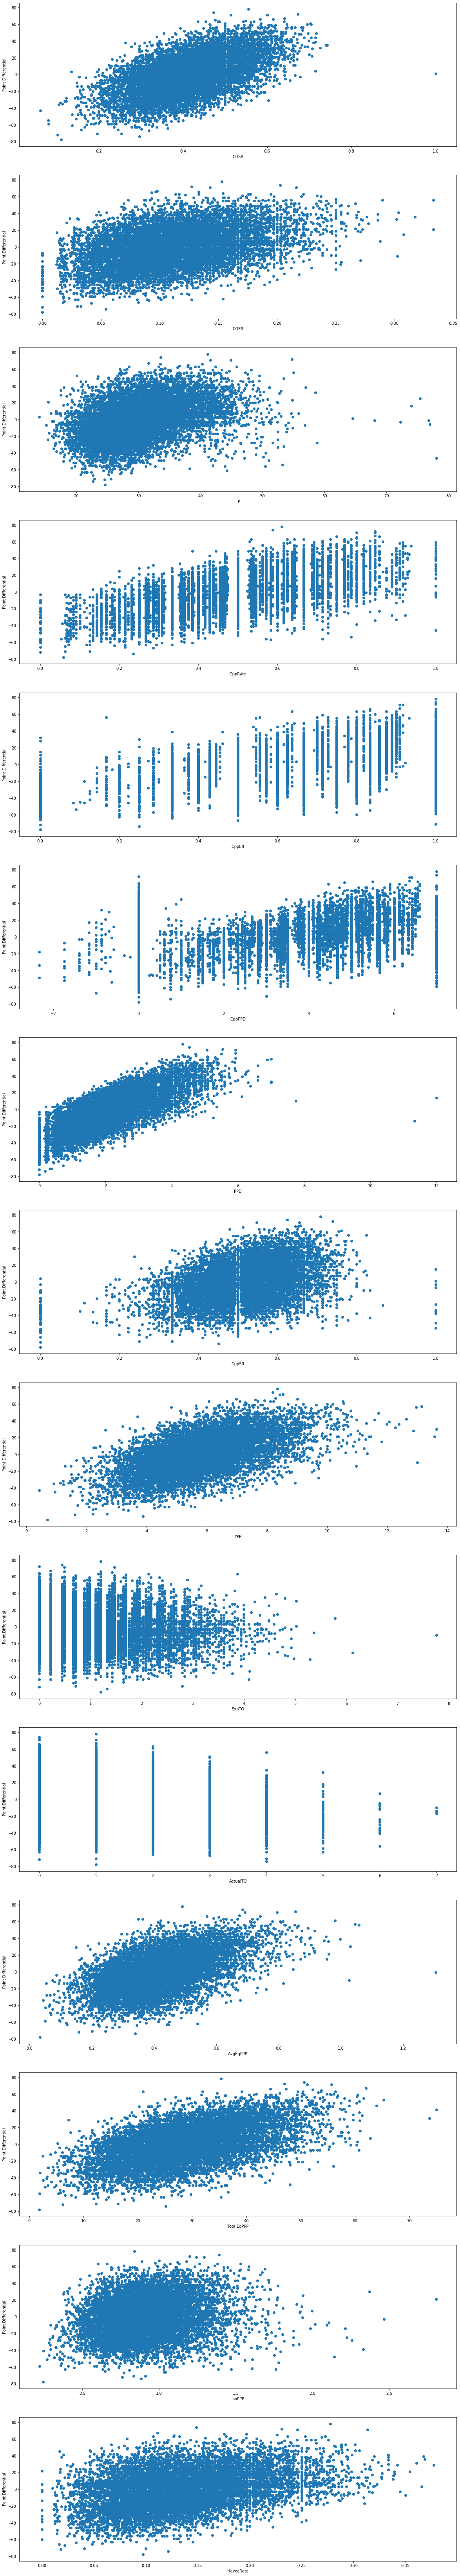

In [14]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

for i in range(len(inputs)):
    inpt = inputs[i]
    axes[i].scatter(stored_game_boxes[inpt], stored_game_boxes.PtsDiff);
    axes[i].set_xlabel(inpt)
    axes[i].set_ylabel("Point Differential");

In [15]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.257956,1.015913,1.008803,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.242044,-1.015913,1.008803,1.907384
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,4.643670,-0.212660,0.211171,0.181656
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.856330,0.212660,0.211171,0.181656
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.346133,-0.807733,0.802080,0.499553


In [16]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3.2)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.2)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [17]:
# outliers

In [18]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.257956,1.015913,1.008803,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.242044,-1.015913,1.008803,1.907384
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,4.643670,-0.212660,0.211171,0.181656
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.856330,0.212660,0.211171,0.181656
1,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,0.00,0,-0.087917,6.578618,-0.26167,-0.059391,5.153867,0.807733,0.802080,0.499553


In [19]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

In [20]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {model.score(train_data["5FRDiff"][:,np.newaxis], train_data.PtsDiff)}\n')
# print(f'Linear Regression Model:\nPtsDiff = {model.intercept_:.5f}')
# for i in range(len(inputDiffs)):
#     inptDf = inputDiffs[i]
#     print(f"+ ({model.coef_[i]:.5f} * {inptDf})")
    
test.corr()

Linear Regression: y = 20.11685x + 0.05953
Mean Pred Score: 0.0043109160497278075
Pred Std Dev: 20.2700496147929
MAPE: ???%
Mean Abs Error: 6.6243326362445965
Mdn Abs Error: 5.2515284379945175
R-squared: 0.8410509328022596



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.774286,0.571513,0.509023,0.805529,0.627966,0.612983,0.983133,0.534349,0.776309,-0.476999,-0.461739,0.726268,0.747350,0.222430,0.558270,0.921083,0.921083,0.921083
OffSRDiff,0.774286,1.000000,0.501228,0.314462,0.704396,0.438811,0.450303,0.770819,0.739887,0.726543,-0.303816,-0.182621,0.659052,0.758267,-0.037259,0.561295,0.810631,0.810631,0.810631
OffERDiff,0.571513,0.501228,1.000000,0.158429,0.507853,0.327523,0.319279,0.561908,0.367956,0.803172,-0.203170,-0.109293,0.759094,0.614767,0.560269,0.212559,0.558675,0.558675,0.558675
FPDiff,0.509023,0.314462,0.158429,1.000000,0.603794,0.158022,0.138657,0.486971,0.094121,0.240491,-0.306953,-0.376559,0.237796,0.240094,0.005479,0.304963,0.646756,0.646756,0.646756
OppRateDiff,0.805529,0.704396,0.507853,0.603794,1.000000,0.274660,0.244087,0.803124,0.309130,0.679531,-0.323849,-0.297082,0.610019,0.742226,0.145727,0.525897,0.901831,0.901831,0.901831
OppEffDiff,0.627966,0.438811,0.327523,0.158022,0.274660,1.000000,0.743827,0.631156,0.535323,0.473311,-0.319462,-0.341695,0.433704,0.389820,0.173148,0.341269,0.523227,0.523227,0.523227
OppPPDDiff,0.612983,0.450303,0.319279,0.138657,0.244087,0.743827,1.000000,0.622123,0.551697,0.473636,-0.349424,-0.327002,0.452894,0.383958,0.184212,0.357572,0.556765,0.556765,0.556765
PPDDiff,0.983133,0.770819,0.561908,0.486971,0.803124,0.631156,0.622123,1.000000,0.534581,0.767690,-0.469056,-0.456651,0.719113,0.723803,0.217906,0.568682,0.916089,0.916089,0.916089
OppSRDiff,0.534349,0.739887,0.367956,0.094121,0.309130,0.535323,0.551697,0.534581,1.000000,0.542179,-0.251510,-0.136090,0.492414,0.455596,-0.011462,0.378245,0.557798,0.557798,0.557798
YPPDiff,0.776309,0.726543,0.803172,0.240491,0.679531,0.473311,0.473636,0.767690,0.542179,1.000000,-0.341721,-0.198855,0.917447,0.791738,0.524411,0.459024,0.762448,0.762448,0.762448


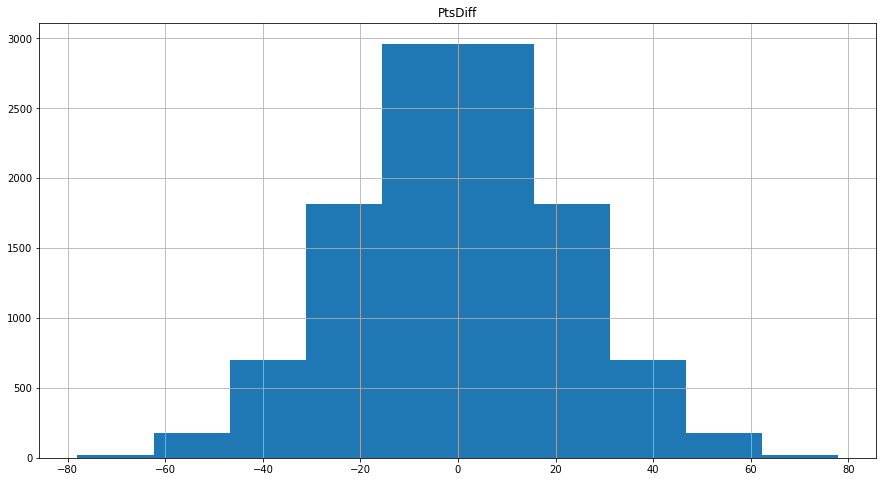

In [59]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

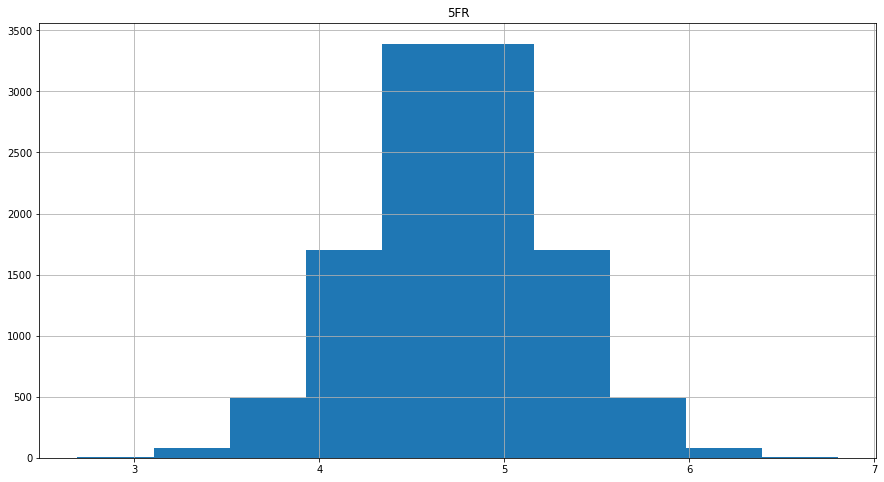

In [64]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

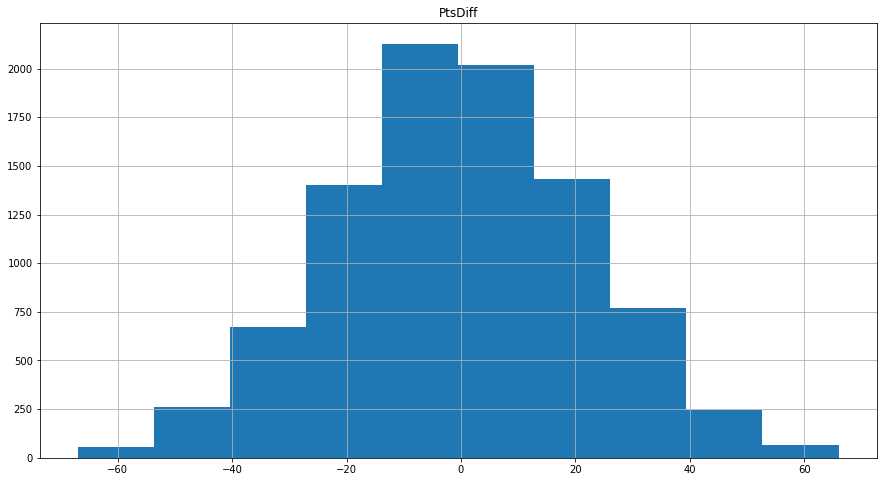

In [58]:
train_data.hist(column='PtsDiff', figsize=(15,8));

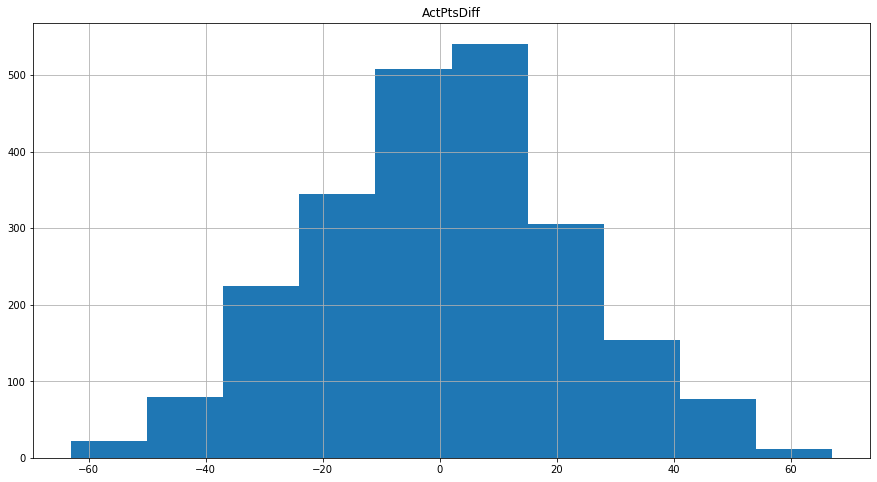

In [56]:
test.hist(column='ActPtsDiff', figsize=(15,8));

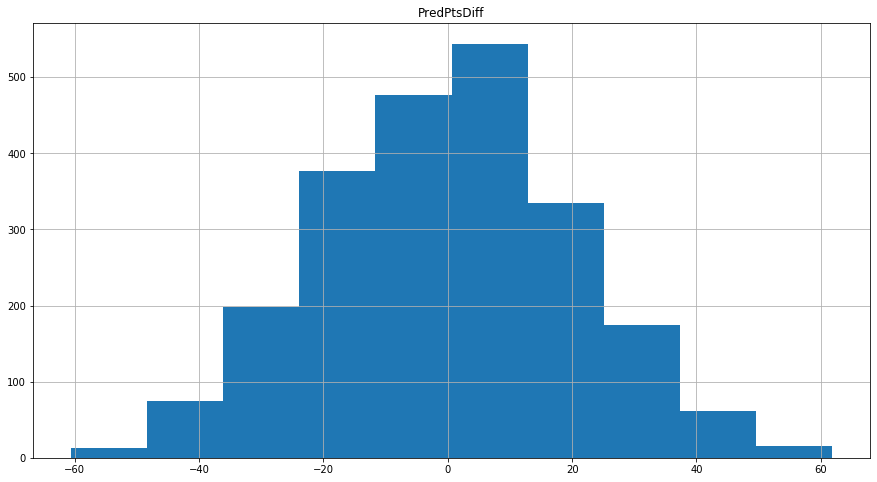

In [57]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [21]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")
    print("---")
    return stats.norm.cdf(z)

In [22]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -2.0 (exact value: -1.6830935849871997)
Z score: -0.08324619490844636
Win Prob for Virginia Tech: 46.68%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,4.793313,0.086625
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.706687,-0.086625


In [23]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -20.0 (exact value: -19.915448723346994)
Z score: -0.982718839763444
Win Prob for Georgia Tech: 16.29%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.253526,-0.992948
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.246474,0.992948


In [24]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by 0.0 (exact value: 0.38118945776865626)
Z score: 0.01859287712072919
Win Prob for Georgia Tech: 50.74%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,4.742005,-0.015989
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.757995,0.015989


In [25]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 2.0 (exact value: 1.6052335540936513)
Z score: 0.07897970989057593
Win Prob for Mississippi State: 53.15%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.711582,-0.076836
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,4.788418,0.076836


In [26]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -3.0 (exact value: -3.0984629555626713)
Z score: -0.1530718439558245
Win Prob for Texas A&M: 43.92%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,4.828491,0.156983
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.671509,-0.156983


In [27]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Clemson,0.939460,13,12.0,1.0
2,Ohio State,0.937819,13,12.0,1.0
3,Alabama,0.917531,12,11.0,1.0
4,LSU,0.890764,13,12.0,1.0
5,Utah,0.852333,13,11.0,2.0
6,Oregon,0.844074,13,11.0,2.0
7,Wisconsin,0.838528,13,11.0,2.0
8,Notre Dame,0.817212,12,10.0,2.0
9,Georgia,0.811997,13,11.0,2.0
10,Oklahoma,0.788018,13,10.0,3.0


In [28]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.521463,1.478537
21,Clemson,10.746234,2.253766
53,LSU,10.140489,2.859511
115,Utah,9.373186,3.626814
2,Alabama,9.328478,2.671522
128,Wisconsin,9.170628,3.829372
82,Oregon,8.974313,4.025687
75,Notre Dame,8.813918,3.186082
34,Georgia,8.810842,4.189158
78,Oklahoma,8.798505,4.201495


In [29]:
# Matchup Predictor?

def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'].median()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'].median()
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.11087979900504052, -24.76290422032193]

In [30]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5] # Sugar Bowl
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Georgia,Baylor,7.5,3.950959,0.577187,False,Georgia,Baylor
0,LSU,Oklahoma,11.0,3.577751,0.569968,False,LSU,Oklahoma
0,Florida,Virginia,14.0,3.428526,0.567074,False,Florida,Virginia
0,Penn State,Memphis,7.0,-0.077687,0.498386,False,Memphis,Memphis
0,Clemson,Ohio State,2.5,-0.624098,0.487634,False,Ohio State,Ohio State
0,Wisconsin,Oregon,2.5,-5.916723,0.385102,False,Oregon,Oregon


In [31]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 6.0 (exact value: 6.470407033052272)
Z score: 0.3189975476075621
Win Prob for Virginia: 62.51%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,0.073684,-2.332187,0.66,3,-0.135068,2.373916,-0.403644,-0.089435,4.590659,-0.318682
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,-0.073684,2.332187,-0.66,-3,0.135068,-2.373916,0.403644,0.089435,4.909341,0.318682


In [32]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.971840562728675)
Z score: 0.5410706858198779
Win Prob for North Carolina: 70.58%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.123887,-0.349659,0.0,-1,-0.01403,15.633715,-0.235394,0.079888,5.021223,0.542446
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.123887,0.349659,0.0,1,0.01403,-15.633715,0.235394,-0.079888,4.478777,-0.542446


In [33]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 13.0 (exact value: 12.615485679288113)
Z score: 0.6221580609272345
Win Prob for Pittsburgh: 73.31%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.20743,1.49512,0.0,1,0.130501,14.249196,-0.248736,0.038746,5.062075,0.624151
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.20743,-1.49512,0.0,-1,-0.130501,-14.249196,0.248736,-0.038746,4.437925,-0.624151


In [34]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -7.0 (exact value: -6.85695383334634)
Z score: -0.33849274569060644
Win Prob for Auburn: 36.75%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,0.114729,1.117419,0.44,1,0.063274,9.532495,-0.083465,-0.033763,4.921908,0.343815
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,-0.114729,-1.117419,-0.44,-1,-0.063274,-9.532495,0.083465,0.033763,4.578092,-0.343815


In [35]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 33.0 (exact value: 33.180625764466626)
Z score: 1.6367160159393555
Win Prob for Georgia: 94.92%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,-0.047059,4.45067,0.0,2,0.330151,25.998278,0.455922,0.020115,5.573218,1.646435
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,0.047059,-4.45067,0.0,-2,-0.330151,-25.998278,-0.455922,-0.020115,3.926782,-1.646435


In [36]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)
    return prob if row.ActualMOV > 0 else 1-prob

def retrieve_win_probs(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame

retrieve_win_probs("Georgia Tech", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 23.0 (exact value: 23.366731029784315)
Z score: 1.1525586053171228
Win Prob for Clemson: 87.55%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 4.0 (exact value: 3.679917412347246)
Z score: 0.18133189440321318
Win Prob for Georgia Tech: 57.19%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -12.0 (exact value: -12.06449973876015)
Z score: -0.5954011403110808
Win Prob for The Citadel: 27.58%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 19.0 (exact value: 18.92090961762033)
Z score: 0.9332290281009199
Win Prob for Temple: 82.46%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.971840562728675)
Z score: 0.5410706858198

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5804,401111653,2019,Georgia Tech,Clemson,-38.0,12.454580
5900,401112441,2019,Georgia Tech,South Florida,4.0,57.194646
5967,401112452,2019,Georgia Tech,The Citadel,-3.0,72.421232
6107,401112469,2019,Georgia Tech,Temple,-22.0,17.535087
6164,401112475,2019,Georgia Tech,North Carolina,-16.0,29.422943
6198,401112480,2019,Georgia Tech,Duke,-18.0,31.774476
6251,401112488,2019,Georgia Tech,Miami,7.0,16.287292
6384,401112498,2019,Georgia Tech,Pittsburgh,-10.0,26.691897
6418,401112504,2019,Georgia Tech,Virginia,-5.0,19.949105
6475,401112511,2019,Georgia Tech,Virginia Tech,-45.0,0.051993


In [37]:
retrieve_win_probs("Ohio State", 2019)

Game: Florida Atlantic @ Ohio State
Actual Winner: Ohio State
MOV: Ohio State by 24.0
Proj MOV: Ohio State by 21.0 (exact value: 21.1185850689277)
Z score: 1.0416488639213277
Win Prob for Ohio State: 85.12%
---
Game: Cincinnati @ Ohio State
Actual Winner: Ohio State
MOV: Ohio State by 42.0
Proj MOV: Ohio State by 41.0 (exact value: 40.88471203966554)
Z score: 2.016788409525237
Win Prob for Ohio State: 97.81%
---
Game: Ohio State @ Indiana
Actual Winner: Ohio State
MOV: Ohio State by 41.0
Proj MOV: Ohio State by 37.0 (exact value: 36.60256279367696)
Z score: 1.8055334137375845
Win Prob for Ohio State: 96.45%
---
Game: Miami (OH) @ Ohio State
Actual Winner: Ohio State
MOV: Ohio State by 71.0
Proj MOV: Ohio State by 63.0 (exact value: 62.95732903302425)
Z score: 3.1057160349046202
Win Prob for Ohio State: 99.91%
---
Game: Ohio State @ Nebraska
Actual Winner: Ohio State
MOV: Ohio State by 41.0
Proj MOV: Ohio State by 44.0 (exact value: 43.71194083661694)
Z score: 2.1562665484878627
Win Pro

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5821,401112251,2019,Ohio State,Florida Atlantic,24.0,85.121275
5887,401112252,2019,Ohio State,Cincinnati,42.0,97.814120
5965,401112159,2019,Ohio State,Indiana,41.0,96.450437
6043,401112253,2019,Ohio State,Miami (OH),71.0,99.905091
6125,401112241,2019,Ohio State,Nebraska,41.0,98.446857
6173,401112216,2019,Ohio State,Michigan State,24.0,85.549828
6241,401112248,2019,Ohio State,Northwestern,49.0,98.438431
6307,401112254,2019,Ohio State,Wisconsin,31.0,85.950388
6413,401112209,2019,Ohio State,Maryland,59.0,98.670409
6481,401112255,2019,Ohio State,Rutgers,35.0,95.338830


In [38]:
retrieve_win_probs("Georgia Tech", 2018)

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 48.0 (exact value: 48.00777530306368)
Z score: 2.3681966891675224
Win Prob for Georgia Tech: 99.11%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 13.0 (exact value: 12.968943674541737)
Z score: 0.6395955118447534
Win Prob for South Florida: 73.88%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 7.0 (exact value: 6.628167239334669)
Z score: 0.3267804691731445
Win Prob for Pittsburgh: 62.81%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 23.0 (exact value: 22.98631185189171)
Z score: 1.1337910549103898
Win Prob for Clemson: 87.16%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 39.0 (exact value: 38.937969065486456)
Z sco

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
4986,401013090,2018,Georgia Tech,Alcorn State,41.0,99.106248
5048,401013100,2018,Georgia Tech,South Florida,-11.0,26.121780
5135,401013112,2018,Georgia Tech,Pittsburgh,-5.0,37.191697
5206,401013120,2018,Georgia Tech,Clemson,-28.0,12.844110
5249,401013134,2018,Georgia Tech,Bowling Green,46.0,97.261826
5304,401013138,2018,Georgia Tech,Louisville,35.0,96.711309
5373,401013145,2018,Georgia Tech,Duke,-14.0,19.429396
5473,401013153,2018,Georgia Tech,Virginia Tech,21.0,76.741354
5545,401013165,2018,Georgia Tech,North Carolina,10.0,81.375311
5636,401013172,2018,Georgia Tech,Miami,6.0,62.475335


In [39]:
retrieve_win_probs("Clemson", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 23.0 (exact value: 23.366731029784315)
Z score: 1.1525586053171228
Win Prob for Clemson: 87.55%
---
Game: Texas A&M @ Clemson
Actual Winner: Clemson
MOV: Clemson by 14.0
Proj MOV: Clemson by 13.0 (exact value: 12.593405919866576)
Z score: 0.6210687809382293
Win Prob for Clemson: 73.27%
---
Game: Clemson @ Syracuse
Actual Winner: Clemson
MOV: Clemson by 35.0
Proj MOV: Clemson by 28.0 (exact value: 27.890107676162813)
Z score: 1.3757142824042365
Win Prob for Clemson: 91.55%
---
Game: Charlotte @ Clemson
Actual Winner: Clemson
MOV: Clemson by 42.0
Proj MOV: Clemson by 48.0 (exact value: 48.22896435871037)
Z score: 2.3791088013650805
Win Prob for Clemson: 99.13%
---
Game: Clemson @ North Carolina
Actual Winner: Clemson
MOV: Clemson by 1.0
Proj MOV: Clemson by 0.0 (exact value: 0.0103754584293521)
Z score: 0.0002991873475829306
Win Prob for Clemson: 50.01%
---
Game: Florida State @ Clemson
Actual W

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5804,401111653,2019,Clemson,Georgia Tech,38.0,87.545420
5905,401110784,2019,Clemson,Texas A&M,14.0,73.272282
6008,401112449,2019,Clemson,Syracuse,35.0,91.554495
6067,401112456,2019,Clemson,Charlotte,42.0,99.132272
6103,401112467,2019,Clemson,North Carolina,1.0,50.011936
6204,401112479,2019,Clemson,Florida State,31.0,91.603593
6250,401112485,2019,Clemson,Louisville,35.0,94.418832
6344,401112490,2019,Clemson,Boston College,52.0,94.859963
6381,401112496,2019,Clemson,Wofford,45.0,98.940927
6445,401112503,2019,Clemson,NC State,45.0,96.690610


In [40]:
retrieve_win_probs("Georgia Tech", 2016)

Game: Georgia Tech @ Boston College
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by -6.0 (exact value: -6.233856710788751)
Z score: -0.3077529530211865
Win Prob for Georgia Tech: 37.91%
---
Game: Mercer @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 25.0
Proj MOV: Georgia Tech by 24.0 (exact value: 23.56323927660363)
Z score: 1.1622531176914734
Win Prob for Georgia Tech: 87.74%
---
Game: Vanderbilt @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 31.0
Proj MOV: Georgia Tech by 31.0 (exact value: 30.590980896790363)
Z score: 1.5089588117445336
Win Prob for Georgia Tech: 93.43%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 19.0
Proj MOV: Clemson by 24.0 (exact value: 24.06407506900226)
Z score: 1.1869612857481084
Win Prob for Clemson: 88.24%
---
Game: Miami @ Georgia Tech
Actual Winner: Miami
MOV: Miami by 14.0
Proj MOV: Miami by 7.0 (exact value: 7.3130466457633645)
Z score: 0.3605682210259509
Win P

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
3312,400869424,2016,Georgia Tech,Boston College,3.0,37.913516
3393,400869433,2016,Georgia Tech,Mercer,25.0,87.743367
3462,400869001,2016,Georgia Tech,Vanderbilt,31.0,93.434535
3513,400869446,2016,Georgia Tech,Clemson,-19.0,11.762145
3576,400869721,2016,Georgia Tech,Miami,-14.0,35.921112
3650,400869458,2016,Georgia Tech,Pittsburgh,-3.0,47.654208
3702,400869464,2016,Georgia Tech,Georgia Southern,11.0,80.228065
3807,400869474,2016,Georgia Tech,Duke,3.0,43.055365
3874,400869480,2016,Georgia Tech,North Carolina,-28.0,18.809537
3946,400869486,2016,Georgia Tech,Virginia Tech,10.0,46.765351


In [41]:
retrieve_win_probs("Alabama", 2012)

Game: Michigan @ Alabama
Actual Winner: Alabama
MOV: Alabama by 27.0
Proj MOV: Alabama by 42.0 (exact value: 41.71121464674708)
Z score: 2.057562981999809
Win Prob for Alabama: 98.02%
---
Game: Western Kentucky @ Alabama
Actual Winner: Alabama
MOV: Alabama by 35.0
Proj MOV: Alabama by 32.0 (exact value: 31.830911006870156)
Z score: 1.5701293630575852
Win Prob for Alabama: 94.18%
---
Game: Alabama @ Arkansas
Actual Winner: Alabama
MOV: Alabama by 52.0
Proj MOV: Alabama by 35.0 (exact value: 35.4819855439496)
Z score: 1.7502510009649204
Win Prob for Alabama: 96.00%
---
Game: Florida Atlantic @ Alabama
Actual Winner: Alabama
MOV: Alabama by 33.0
Proj MOV: Alabama by 49.0 (exact value: 48.5381011625938)
Z score: 2.3943597163730943
Win Prob for Alabama: 99.17%
---
Game: Ole Miss @ Alabama
Actual Winner: Alabama
MOV: Alabama by 19.0
Proj MOV: Alabama by 26.0 (exact value: 25.827291699135845)
Z score: 1.2739475864055476
Win Prob for Alabama: 89.87%
---
Game: Alabama @ Missouri
Actual Winner: 

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
67,322450333,2012,Alabama,Michigan,27.0,98.018395
100,322520333,2012,Alabama,Western Kentucky,35.0,94.180749
167,322590008,2012,Alabama,Arkansas,52.0,95.996249
246,322660333,2012,Alabama,Florida Atlantic,33.0,99.167529
326,322730333,2012,Alabama,Ole Miss,19.0,89.865900
414,322870142,2012,Alabama,Missouri,32.0,90.739913
478,322942633,2012,Alabama,Tennessee,31.0,85.980827
551,323010333,2012,Alabama,Mississippi State,31.0,90.142472
606,323080099,2012,Alabama,LSU,4.0,59.108347
638,323150333,2012,Alabama,Texas A&M,-5.0,44.549805


In [42]:
predict_matchup("Georgia Tech","Georgia", 2015)
# calculate_box_score(400547779, 2014)

[0.30892720626701897, -10.108285107083109]

In [43]:
retrieve_win_probs("Georgia Tech", 2015)

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 63.0
Proj MOV: Georgia Tech by 53.0 (exact value: 53.0752668327623)
Z score: 2.618195659372332
Win Prob for Georgia Tech: 99.56%
---
Game: Tulane @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 55.0
Proj MOV: Georgia Tech by 48.0 (exact value: 48.19668232288479)
Z score: 2.3775162035945243
Win Prob for Georgia Tech: 99.13%
---
Game: Georgia Tech @ Notre Dame
Actual Winner: Notre Dame
MOV: Notre Dame by 8.0
Proj MOV: Notre Dame by 9.0 (exact value: 9.390060398795764)
Z score: 0.4630353482655712
Win Prob for Notre Dame: 67.83%
---
Game: Georgia Tech @ Duke
Actual Winner: Duke
MOV: Duke by 14.0
Proj MOV: Duke by 11.0 (exact value: 11.292650218293023)
Z score: 0.5568974677795149
Win Prob for Duke: 71.12%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 7.0
Proj MOV: North Carolina by 12.0 (exact value: 12.166788299854558)
Z score: 0.6000220825768855

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
2460,400756895,2015,Georgia Tech,Alcorn State,63.0,99.558019
2567,400756910,2015,Georgia Tech,Tulane,55.0,99.128516
2641,400756922,2015,Georgia Tech,Notre Dame,-8.0,32.166952
2688,400756933,2015,Georgia Tech,Duke,-14.0,28.879874
2775,400756942,2015,Georgia Tech,North Carolina,-7.0,27.424576
2827,400756948,2015,Georgia Tech,Clemson,-19.0,25.841223
2882,400756955,2015,Georgia Tech,Pittsburgh,-3.0,23.565500
2965,400756962,2015,Georgia Tech,Florida State,6.0,18.468083
2997,400756972,2015,Georgia Tech,Virginia,-6.0,24.751850
3090,400756979,2015,Georgia Tech,Virginia Tech,-2.0,25.436217


In [44]:
predict_matchup("Georgia Tech","Florida State",2015)

[0.22058035468990378, -15.608383789898323]

In [45]:
predict_matchup("Army","Navy", 2019)

[0.334765344948902, -8.646788106475652]

In [46]:
retrieve_win_probs("Georgia Tech", 2015)

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 63.0
Proj MOV: Georgia Tech by 53.0 (exact value: 53.0752668327623)
Z score: 2.618195659372332
Win Prob for Georgia Tech: 99.56%
---
Game: Tulane @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 55.0
Proj MOV: Georgia Tech by 48.0 (exact value: 48.19668232288479)
Z score: 2.3775162035945243
Win Prob for Georgia Tech: 99.13%
---
Game: Georgia Tech @ Notre Dame
Actual Winner: Notre Dame
MOV: Notre Dame by 8.0
Proj MOV: Notre Dame by 9.0 (exact value: 9.390060398795764)
Z score: 0.4630353482655712
Win Prob for Notre Dame: 67.83%
---
Game: Georgia Tech @ Duke
Actual Winner: Duke
MOV: Duke by 14.0
Proj MOV: Duke by 11.0 (exact value: 11.292650218293023)
Z score: 0.5568974677795149
Win Prob for Duke: 71.12%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 7.0
Proj MOV: North Carolina by 12.0 (exact value: 12.166788299854558)
Z score: 0.6000220825768855

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
2460,400756895,2015,Georgia Tech,Alcorn State,63.0,99.558019
2567,400756910,2015,Georgia Tech,Tulane,55.0,99.128516
2641,400756922,2015,Georgia Tech,Notre Dame,-8.0,32.166952
2688,400756933,2015,Georgia Tech,Duke,-14.0,28.879874
2775,400756942,2015,Georgia Tech,North Carolina,-7.0,27.424576
2827,400756948,2015,Georgia Tech,Clemson,-19.0,25.841223
2882,400756955,2015,Georgia Tech,Pittsburgh,-3.0,23.565500
2965,400756962,2015,Georgia Tech,Florida State,6.0,18.468083
2997,400756972,2015,Georgia Tech,Virginia,-6.0,24.751850
3090,400756979,2015,Georgia Tech,Virginia Tech,-2.0,25.436217


In [47]:
retrieve_win_probs("Georgia Tech", 2013)

Game: Elon @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 70.0
Proj MOV: Georgia Tech by 38.0 (exact value: 38.28722876344952)
Z score: 1.8886445062996424
Win Prob for Georgia Tech: 97.05%
---
Game: Georgia Tech @ Duke
Actual Winner: Georgia Tech
MOV: Georgia Tech by 24.0
Proj MOV: Georgia Tech by 20.0 (exact value: 20.06753406882162)
Z score: 0.9897964501344847
Win Prob for Georgia Tech: 83.89%
---
Game: North Carolina @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 8.0
Proj MOV: Georgia Tech by 1.0 (exact value: 0.7473977716397084)
Z score: 0.03665935060404009
Win Prob for Georgia Tech: 51.46%
---
Game: Virginia Tech @ Georgia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 7.0
Proj MOV: Virginia Tech by 10.0 (exact value: 10.170671432544921)
Z score: 0.5015459118104909
Win Prob for Virginia Tech: 69.20%
---
Game: Georgia Tech @ Miami
Actual Winner: Miami
MOV: Miami by 15.0
Proj MOV: Miami by 11.0 (exact value: 11.135216506330584)
Z score: 0.5

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
831,332430059,2013,Georgia Tech,Elon,70.0,97.053026
982,332570150,2013,Georgia Tech,Duke,24.0,83.886319
1025,332640059,2013,Georgia Tech,North Carolina,8.0,51.462169
1077,332690059,2013,Georgia Tech,Virginia Tech,-7.0,30.799349
1156,332782390,2013,Georgia Tech,Miami,-15.0,29.145790
1220,332850252,2013,Georgia Tech,BYU,-18.0,29.706115
1246,332920059,2013,Georgia Tech,Syracuse,56.0,97.963981
1294,332990258,2013,Georgia Tech,Virginia,10.0,54.018047
1378,333060059,2013,Georgia Tech,Pittsburgh,11.0,74.641192
1445,333180228,2013,Georgia Tech,Clemson,-24.0,7.666030


In [48]:
predict_matchup("Georgia Tech","Syracuse",2013)

[0.5248098598008065, 1.2657006234175339]

In [49]:
generate_win_prob(401013177,2018)

Game: Virginia @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by -3.0 (exact value: -2.707118362001517)
Z score: -0.13376530050880922
Win Prob for Georgia Tech: 44.68%
---


0.44679408336435444

In [50]:
predict_matchup("Georgia Tech","Georgia",2016)

[0.4477476900875498, -2.6582385108959357]

In [51]:
predict_matchup("Georgia Tech","Georgia",2015)

[0.30892720626701897, -10.108285107083109]

In [53]:
# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)